# Orbitrap data treatment 
    Inputs: a series of .isox files and a sequence.csv file, for a series of Vanquish injections
    Outputs: an excel file compiling all the results from each step of calculation:
        - block averages
        - bracketed deltas for each sample and a statistical summary
        - statistical summary of internationally referenced deltas

## 1. Data and sequence import and pretreatment  
#### a. Import .isox data and sequence file from pathdata  
#### b. Selection of injection plateau and filtering of outlying scans  
        i.Filter using t_start and t_end  
        ii. Filter using TIC thresholds lower_threshold and upper_threshold relative to median TIC  
        iii. Filter scans by TICxIT - remove outlying fraction_to_discard  
        iv. Remove data for isotoplogues detected in only a few scans using isotopologue_threshold  
 #### c. Verification of data quality  
        i. Check variability in Orbtirap analyser temperature  
        ii. Check peak resolution range for weakest isotopologues  
        iii. Check the time period extracted for outlying blocks
## 2. Block verification and filtering
#### a. Extract block average ratios  
#### b. Check for outlying behaviour between blocks
        e.g. trends in TIC or isotopes, check for empty vials (no signal)
#### c. Check for outlying behaviour within blocks
        e.g. TIC jumps that affect d18O values
#### d. Filtering of blocks
        Select blocks to remove, or use simple filters
## 3. Calculation of delta values
#### a. Bracketing
        Error propagation: maximum between sem of injections and propogated error value
#### b. Correction to international scale using known value of internal standard
        Input ref_filename

## 4. Plots of final results
        Averages for small deltas and D17O

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
current_datetime = datetime.now()
current_date_string = current_datetime.strftime("%Y-%m-%d")

# INPUTS

pathdata = 'data'
seq_filename = 'sequence.csv'
ref_filename = [fn for fn in os.listdir() if fn.startswith('references_') and fn.endswith('.xlsx')][0]

pathresults = 'results_'+current_date_string
output_file = 'results_'+current_date_string+'.xlsx'

# create folder for sorted output
def create_folder(directory, folder_name):
    # Combine the directory path and folder name
    folder_path = os.path.join(directory, folder_name)
    
    # Check if the folder doesn't already exist
    if not os.path.exists(folder_path):
        try:
            # Create the folder
            os.makedirs(folder_path)
            print(f"Folder '{folder_name}' created successfully at '{directory}'.")
        except OSError as e:
            print(f"Error creating folder: {e}")
    else:
        print(f"Folder '{folder_name}' already exists at '{directory}'.")

create_folder('',pathresults)

Folder 'results_2024-10-23' created successfully at ''.


## 1. Data and sequence import and pretreatment  
#### a.  Import of .isox data and sequence file from pathdata

In [2]:
# Import sequence file

seq = pd.read_csv(os.path.join(pathdata,seq_filename),header=1)
seq = seq.loc[:,[col for col in seq.columns if col not in ['Process Method','Calibration File','Comment']]]

# fill in compound and experiment column based on method file name
seq['Expt']=''
seq['Compound']=''
for i in seq.index:
    if 'NO3' in seq.loc[i,'Instrument Method']:
        seq.loc[i,'Compound'] = 'NO3'
    elif 'SO4' in seq.loc[i,'Instrument Method']:
        seq.loc[i,'Compound'] = 'SO4'
    if ('noM0' in seq.loc[i,'Instrument Method']) or ('nom0' in seq.loc[i,'Instrument Method']):
        seq.loc[i,'Expt']='noM0'
    elif 'Full_spectrum' in seq.loc[i,'Instrument Method']:
        seq.loc[i,'Expt']='Full spectrum'
        seq.loc[i,'Compound']=''
    else:
        seq.loc[i,'Expt']='M0'
        
# display
seq.groupby('Position').first().sort_values('Sample ID')

Sample Type   File Name  Sample ID  \
Position                                      
Y:F1         Unknown  241018_001          1   
Y:A1         Unknown  241018_007          7   
Y:A2         Unknown  241018_008          8   
Y:A3         Unknown  241018_009          9   
Y:A4         Unknown  241018_010         10   
Y:A6         Unknown  241018_012         12   
Y:A7         Unknown  241018_024         24   
Y:A8         Unknown  241018_036         36   
Y:A9         Unknown  241018_048         48   
Y:F2         Unknown  241018_057         57   
Y:B1         Unknown  241018_060         60   
Y:B2         Unknown  241018_072         72   
Y:B3         Unknown  241018_084         84   
Y:B4         Unknown  241018_096         96   
Y:B5         Unknown  241018_108        108   
Y:F3         Unknown  241018_115        115   
Y:B6         Unknown  241018_120        120   
Y:B7         Unknown  241018_132        132   
Y:B8         Unknown  241018_144        144   
Y:B9         Unknown  241018_156        156   
Y:C1         Unknown  241018_168        168   
Y:F4         Unknown  241018_173        173   

                                                       Path  \
Position                                                      
Y:F1      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:A1      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:A2      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:A3      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:A4      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:A6      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:A7      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:A8      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:A9      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:F2      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:B1      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:B2      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:B3      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:B4      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:B5      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:F3      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:B6      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:B7      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:B8      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:B9      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:C1      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   
Y:F4      C:\Xcalibur\data\DC aerosol\241002_DC_1_rotova...   

                                          Instrument Method  Inj Vol  Level  \
Position                                                                      
Y:F1      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25    NaN   
Y:A1      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25    NaN   
Y:A2      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25    NaN   
Y:A3      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25    NaN   
Y:A4      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25    NaN   
Y:A6      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25    NaN   
Y:A7      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25    NaN   
Y:A8      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25    NaN   
Y:A9      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25    NaN   
Y:F2      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25    NaN   
Y:B1      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25    NaN   
Y:B2      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25    NaN   
Y:B3      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25    NaN   
Y:B4      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25    NaN   
Y:B5      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25    NaN   
Y:F3      C:\Xcalibur\me

#### b. Selection of injection plateau and filtering of outlying scans¶
        i.Filter using t_start and t_end  
        ii. Filter using TIC thresholds lower_threshold and upper_threshold relative to median TIC  
        iii. Filter scans by TICxIT - remove outlying fraction_to_discard  
        iv. Remove data for isotoplogues detected in only a few scans using isotopologue_threshold  

In [3]:
# data pretreatment
# load and filter .isox files from pathdata if their names appear in sequence file

print('Sequence file has',len(seq),'entries')

files = os.listdir(pathdata)

data_compiled = pd.DataFrame()

for i in seq.index:
    fn = seq.loc[i,'File Name']
    
    if fn+'.isox' in files:
        
        # load data
        data = pd.read_csv(os.path.join(pathdata,fn+'.isox'),delimiter='\t')
        
        # populate 'commpound', 'basepeak','position','sample ID','notes' columns in data
        if seq.loc[i,'Expt'] in ['M0','noM0']:
            
            data['compound']=seq.loc[i,'Compound']
            data['position']=seq.loc[i,'Position']
            data['sample_ID']=seq.loc[i,'Sample ID']
            data['sample_name']=seq.loc[i,'Sample Name']
            data['sample_type']=seq.loc[i,'Sample Type']
            if 'Notes' in seq.columns:
                data['notes']=seq.loc[i,'Notes']
            else:
                data['notes']=''
            if seq.loc[i,['Compound','Expt']].tolist()==['NO3','noM0']:
                data['basepeak']='15N'
            elif seq.loc[i,['Compound','Expt']].tolist()==['SO4','noM0']:
                data['basepeak']='34S'
            elif seq.loc[i,'Expt']=='M0':
                data['basepeak']='M0'
            data_to_filter = data.groupby('scan.no').first()

            # filter 1: time window
            t_start = 0.5
            t_end = 6
            data_to_filter = data_to_filter[(data_to_filter['time.min']>t_start)&(data_to_filter['time.min']<t_end)]

            # filter 2: TIC thresholds relative to median TIC - identifies 'plateau region' , removes extreme peaks in TIC
            lower_threshold = 0.8
            upper_threshold = 1.2
            median = data_to_filter['tic'].median()
            data_to_filter = data_to_filter[(data_to_filter['tic']>lower_threshold*median)&(data_to_filter['tic']<upper_threshold*median)]

            # filter 3: TICxIT window - discards the scans with extreme high/low TICxIT (Orbitrap ion population)
            TICxIT = data_to_filter['tic']*data_to_filter['it.ms']
            fraction_to_discard = 0.05
            upper = TICxIT.quantile(1-fraction_to_discard/2)
            lower = TICxIT.quantile(fraction_to_discard/2)
            data_to_filter = data_to_filter[(TICxIT>lower)&(TICxIT<upper)]
            
            TICxIT = data_to_filter['tic']*data_to_filter['it.ms']
            relative_cutoff = 0.02 # mean +- this fraction
            upper = TICxIT.mean()*(1+relative_cutoff)
            lower = TICxIT.mean()*(1-relative_cutoff)
            data_to_filter = data_to_filter[(TICxIT>lower)&(TICxIT<upper)]

            data = data[data['scan.no'].isin(data_to_filter.index)]

            # filter 4: select isotopologues that appear in most scans
            isotopologue_threshold=0.9
            n_scans = len(data[data['isotopolog']==data['basepeak']])
            def count_iso(data_single_iso):
                # remove isotopologues detected in <threshold scans
                if len(data_single_iso)>isotopologue_threshold*n_scans:
                    return data_single_iso
                else:
                    data_single_iso_too_low = data_single_iso.copy()
                    data_single_iso_too_low['scan.no']=np.nan
                    return data_single_iso_too_low
            data = data.groupby('isotopolog').apply(count_iso, include_groups=False).reset_index()
            data.drop(columns = 'level_1', inplace=True)
            data.dropna(subset=['scan.no'],inplace=True) # clean df by removing rows where low abundance isotoplogues were identified

            # Filter 5: select only most abundant identified peak
            data = data.loc[data.groupby(['filename', 'compound', 'isotopolog','scan.no'])['ions.incremental'].idxmax()]


            # calculation of ratio of peaks to basepeak
            def calc_ratio(scan):
                scan['ratio_to_basepeak'] = scan['ions.incremental'] / scan.loc[scan['isotopolog']==scan['basepeak'],'ions.incremental'].iloc[0]
                return scan
            data=data.groupby('scan.no').apply(calc_ratio,include_groups=False)
            data.reset_index(inplace=True)
            data.drop(columns='level_1',inplace=True)

            data_compiled = pd.concat([data_compiled,data], ignore_index=True)

            print('Pretreated data file:',fn+'.isox', '(expt = '+seq.loc[i,'Expt']+',', len(data.groupby('scan.no').first()),'scans)')
            
        else:
            print('File',fn,"doesn't have M0 or noM0 method in sequence file. Ignoring this file")
    else:
        print('File',fn+'.isox not found at',pathdata)

# order columns usefully
first_cols =['sample_ID','filename','sample_type','sample_name','position','scan.no','time.min','basepeak','isotopolog','ions.incremental','ratio_to_basepeak','tic','it.ms','notes']
data_compiled= data_compiled[first_cols+[col for col in data_compiled.columns if col not in first_cols]]
data_compiled.groupby('sample_ID').first().reset_index()[first_cols]  

n_files = len(data_compiled['filename'].unique())
print('Loaded',n_files,'files out of',len(seq))

# display first scan for each sample
data_compiled.groupby('sample_ID').first().reset_index()[first_cols]

Sequence file has 179 entries
Pretreated data file: 241018_001.isox (expt = M0, 247 scans)
Pretreated data file: 241018_002.isox (expt = M0, 244 scans)
Pretreated data file: 241018_003.isox (expt = M0, 251 scans)
Pretreated data file: 241018_004.isox (expt = M0, 251 scans)
Pretreated data file: 241018_005.isox (expt = M0, 271 scans)
Pretreated data file: 241018_006.isox (expt = M0, 257 scans)
Pretreated data file: 241018_007.isox (expt = M0, 43 scans)
Pretreated data file: 241018_008.isox (expt = M0, 29 scans)
Pretreated data file: 241018_009.isox (expt = M0, 96 scans)
Pretreated data file: 241018_010.isox (expt = M0, 135 scans)
Pretreated data file: 241018_011.isox (expt = M0, 251 scans)
Pretreated data file: 241018_012.isox (expt = M0, 297 scans)
Pretreated data file: 241018_013.isox (expt = M0, 269 scans)
Pretreated data file: 241018_014.isox (expt = M0, 294 scans)
Pretreated data file: 241018_015.isox (expt = M0, 244 scans)
Pretreated data file: 241018_016.isox (expt = M0, 295 scan

sample_ID    filename sample_type sample_name position  scan.no  \
0            1  241018_001     Unknown       S1-IS     Y:F1     19.0   
1            2  241018_002     Unknown       S1-IS     Y:F1     21.0   
2            3  241018_003     Unknown       S1-IS     Y:F1     22.0   
3            4  241018_004     Unknown       S1-IS     Y:F1     25.0   
4            5  241018_005     Unknown       S1-IS     Y:F1     25.0   
..         ...         ...         ...         ...      ...      ...   
174        175  241018_175     Unknown       S1-IS     Y:F4     19.0   
175        176  241018_176     Unknown        S2-2     Y:C1     23.0   
176        177  241018_177     Unknown       S1-IS     Y:F4     16.0   
177        178  241018_178     Unknown        S2-2     Y:C1     24.0   
178        179  241018_179     Unknown       S1-IS     Y:F4     15.0   

     time.min basepeak isotopolog  ions.incremental  ratio_to_basepeak  \
0       0.519       M0        17O        596.701157           0.001575   
1       0.513       M0        17O        589.794429           0.001564   
2       0.502       M0        17O        564.191246           0.001495   
3       0.548       M0        17O        560.201501           0.001469   
4       0.544       M0        17O        574.018065           0.001506   
..        ...      ...        ...               ...                ...   
174     0.575       M0        17O        570.932920           0.001483   
175     0.581       M0        17O        610.414232           0.001590   
176     0.520       M0        17O        578.195594           0.001519   
177     0.596       M0        17O        580.903746           0.001522   
178     0.509       M0        17O        573.795170           0.001513   

             tic   it.ms notes  
0    251220928.0   4.168        
1    256347904.0   4.024        
2    258011056.0   4.051        
3    264118976.0   3.955        
4    257324656.0   3.982        
..           ...     ...   ...  
174  161330432.0   6.552        
175   36517100.0  28.059        
176  152536000.0   6.791        
177   36019652.0  28.689        
178  143296384.0   7.214        

[179 rows x 14 columns]

In [4]:
# saves this large csv file
data_compiled.to_csv(os.path.join(pathresults,'scandata_filtered.csv'))

#### c. Verification of data quality  
        i. Check variability in Orbtitrap analyser temperature and m/z migration 
        ii. Check peak resolution range for weakest isotopologues  
        iii. Check the time period extracted for outlying blocks

Temperature range = 0.86 celcius
17O peak has m/z range 0.53 mmu


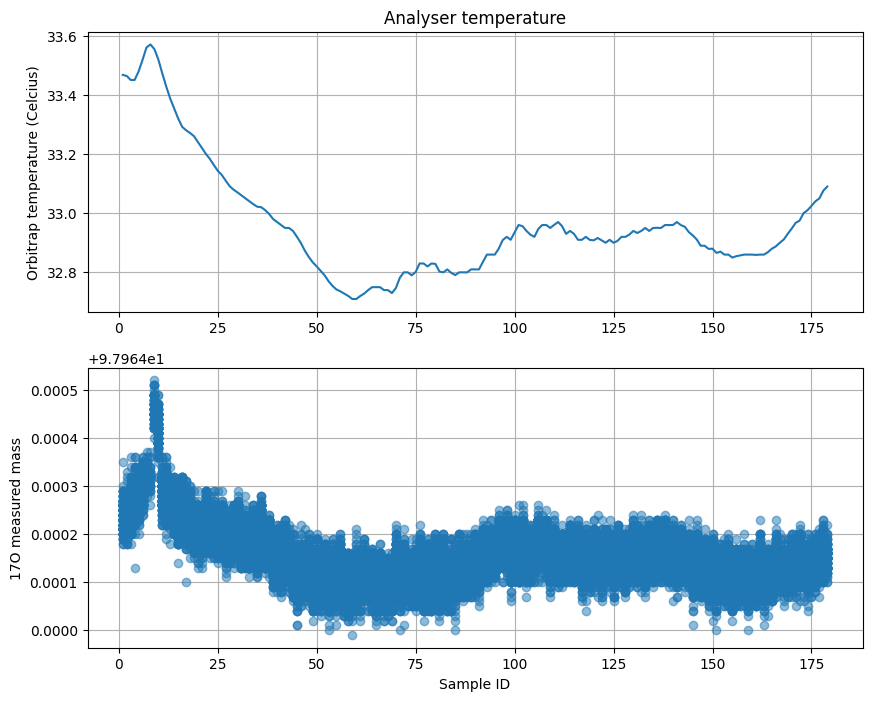

In [5]:
# Check 1:
# plot orbitrap temprature variations during run - variability may affect mass accuracy

fig,ax = plt.subplots(2, figsize=[10,8])
T = data_compiled.groupby('sample_ID')['analyzerTemperature'].mean()
ax[0].plot(T)
ax[0].set_ylabel('Orbitrap temperature (Celcius)')
ax[0].set_title('Analyser temperature')
ax[0].grid()

temp_range = T.max()-T.min()
print(f"Temperature range = {temp_range:.2f} celcius")

iso='17O'
data_i = data_compiled[data_compiled['isotopolog']==iso]
ax[1].plot(data_i['sample_ID'],data_i['mzMeasured'],lw=0,marker='o', alpha=0.5)
ax[1].grid()
ax[1].set_ylabel(iso+' measured mass')
ax[1].set_xlabel('Sample ID')
mz_range = data_i['mzMeasured'].max()-data_i['mzMeasured'].min()
print(f"{iso} peak has m/z range {mz_range*1e3:.2f} mmu")

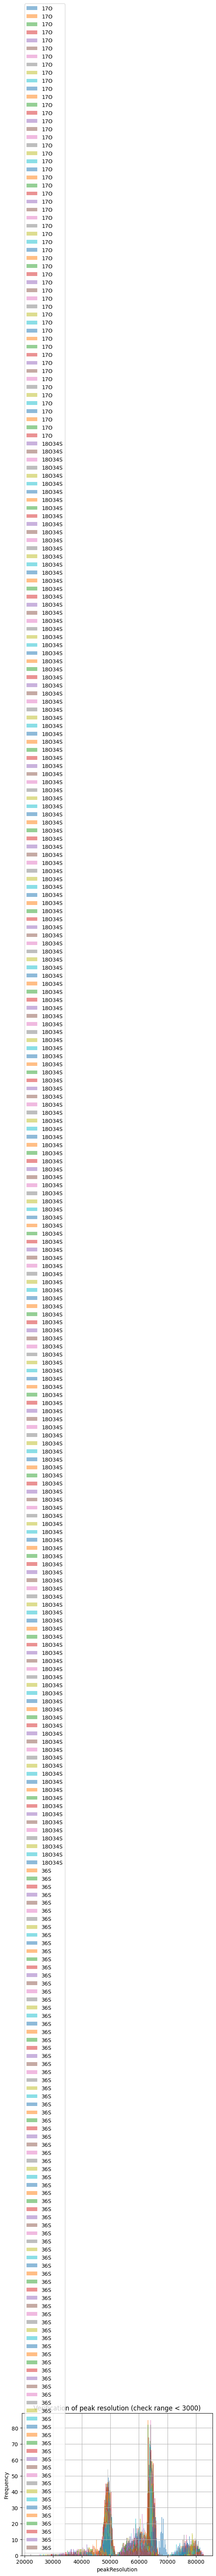

In [6]:
# Check 2:
# verify that the range of peakResolution values < 3000 for all isotopologues

def func(data_single_iso,n):
    # Extract the 'isotopolog' label
    isotopolog_label = index[0]
    # Plot the histogram
    bin_width=250
    min_val = data_single_iso['peakResolution'].min()
    max_val = data_single_iso['peakResolution'].max()
    if max_val-min_val>3000:
        print('Warning: peak resolution range > 3000 for',isotopolog_label,'.','Delta R =',max_val-min_val,'Injection',index[1])
        n+=1
        bins = np.arange(min_val, max_val + bin_width, bin_width)
        data_single_iso['peakResolution'].hist(bins=bins,alpha=0.5, label=isotopolog_label)  
    return n
        
    
# Group by 'isotopolog' and apply the function
n=0   # count instances of >3000
for index, group in data_compiled.groupby(['isotopolog', 'filename']):
    n = func(group, n)
if n==0:
    print('All isotopologue peak resolution ranges are < 3000')
else:
    # Show the plots
    plt.title('Verification of peak resolution (check range < 3000)')
    plt.xlabel('peakResolution')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


C:\Users\Thermo\AppData\Local\Temp\ipykernel_14720\689437683.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(t_list, labels=ID_list, whis=[0,100],vert=False,patch_artist=True)


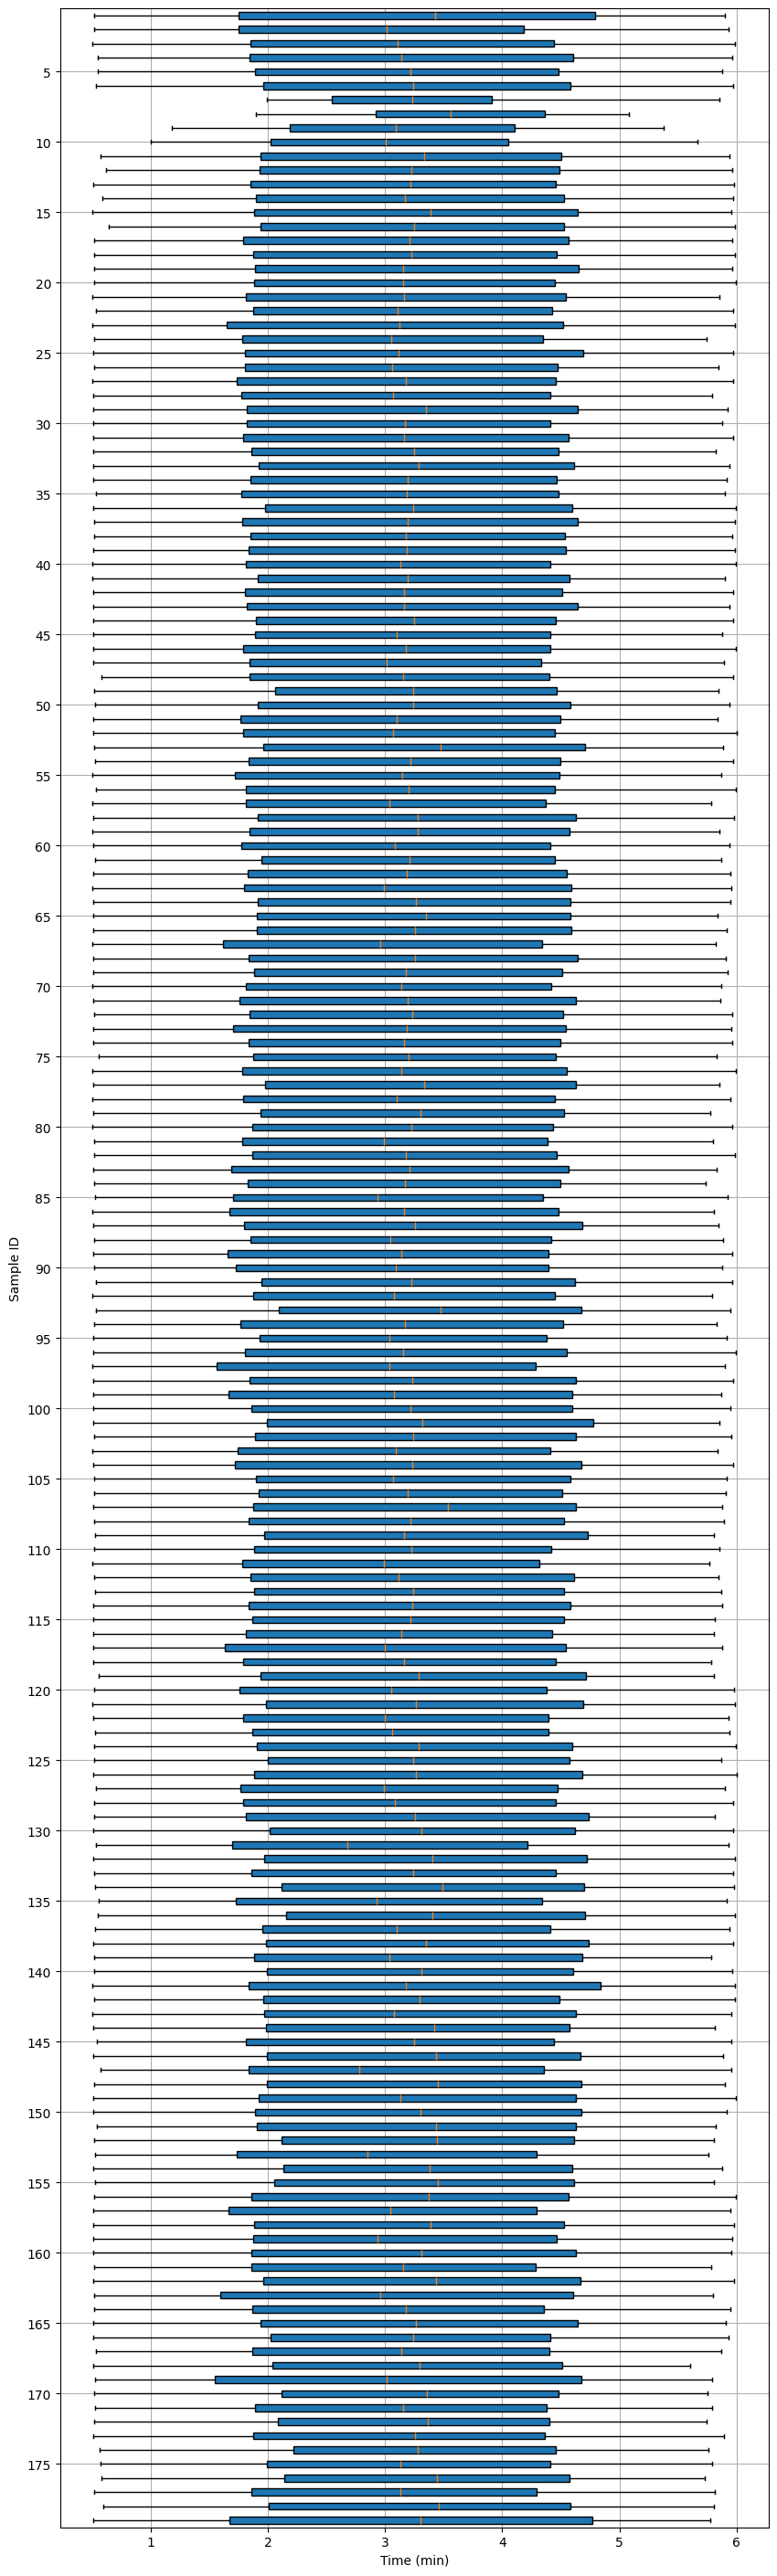

In [7]:
# Check 3:
# plot extracted time periods - check for anomolies

def extract_times(injection_data):
    t = injection_data[['time.min','sample_type']]
    return t

# Group by 'sample_ID' and apply the function
t = data_compiled.groupby('sample_ID').apply(extract_times, include_groups=False)

t_list = [t_group['time.min'].values for name, t_group in t.groupby('sample_ID')]
type_list = [type for type in t.groupby('sample_ID').first()['sample_type']]
ID_list = [int(ID) for ID in t.index.levels[0]]

# colours
colorlist=type_list.copy()
for i,type in enumerate(type_list):
    if type == 'Internal standard':
        colorlist[i]='#1f77b4'
    if type == 'Standard':
        colorlist[i]='#ff7f0e'
    if type == 'Sample':
        colorlist[i]='#2ca02c'
    if type == 'Unknown':
        colorlist[i]='#1f77b4'

fig,ax = plt.subplots(figsize=(10, 0.2*len(ID_list)))
boxplot = ax.boxplot(t_list, labels=ID_list, whis=[0,100],vert=False,patch_artist=True)

# Customizing each box with different colors
for patch, color in zip(boxplot['boxes'], colorlist):
    patch.set_facecolor(color)


ax.set_ylabel('Sample ID')
ax.set_xlabel('Time (min)')
ax.grid()
ax.invert_yaxis()
ax.set_yticks([val for val in ax.get_yticks() if val%5==0])
ax.set_yticklabels([val for val in ax.get_yticks() if val%5==0]);

## 2. Data verification and filtering
#### a. Extract block averages from scan data

In [8]:
# uses groupby() to calculate averages, copies all other data to a summary dataframe 'summ'

data = data_compiled.copy()
data['blockname']=data['filename'].copy()

data=data[data['isotopolog'].isin(['M0','34S','33S','17O','18O'])]

# Extract blocknames
blocknames = data.groupby('sample_ID').first()['blockname']
isotopologues = [iso for iso in data[data['isotopolog']!=data['basepeak']]['isotopolog'].unique()]
# DataFrame for metadata
summ = pd.DataFrame(columns=['sample_ID','filename','sample_type','sample_name','position','blockname','compound','basepeak']+['ratio_'+iso for iso in isotopologues]+['sem_'+iso for iso in isotopologues]+['start_t_min','stop_t_min','scans','TIC_av','TIC_rse','TICxIT_av','TICxIT_std','integration_t_ms','scan_dur_ms','analyser_temp','notes'],index=blocknames)

for block,data_b in data.groupby('blockname'):
    summ.loc[block,['sample_ID','filename','sample_type','sample_name','position','blockname','compound','basepeak','notes']] = data_b[['sample_ID','filename','sample_type','sample_name','position','blockname','compound','basepeak','notes']].iloc[0]
    bp = data_b.loc[:,'basepeak'].iloc[0]
    
    for iso,data_bi in data_b.groupby('isotopolog'):
        if iso == bp:
            summ.loc[block,'start_t_min'] = data_bi['time.min'].min()
            summ.loc[block,'stop_t_min'] = data_bi['time.min'].max()
            summ.loc[block,'scans'] = len(data_bi)
            summ.loc[block,'TIC_av']= data_bi['tic'].mean()
            summ.loc[block,'TIC_rse']= data_bi['tic'].std()/data_bi['tic'].mean()
            summ.loc[block,'TICxIT_av']=np.mean(data_bi['tic']*data_bi['it.ms'])
            summ.loc[block,'TICxIT_std']=np.std(data_bi['tic']*data_bi['it.ms'])
            summ.loc[block,'integration_t_ms']= data_bi['it.ms'].mean()
            summ.loc[block,'scan_dur_ms'] = data_bi['time.min'].diff().median()*60*1000
            summ.loc[block,'analyser_temp'] = data_bi['analyzerTemperature'].mean()
        if iso!=bp:
            summ.loc[block,'ratio_'+iso] = data_bi['ratio_to_basepeak'].mean()
            summ.loc[block,'sem_'+iso] = data_bi['ratio_to_basepeak'].sem()
            
print('Loaded '+ str(len(blocknames)) + ' sorted data blocks for samples:\n',summ[summ['sample_type']!='Internal standard']['sample_name'].unique())

summ.groupby('sample_name').first()

Loaded 179 sorted data blocks for samples:
 ['S1-IS' 'MeOH' 'MQ-0' 'MQ-1' 'MQ-2' 'S1-1' 'S2-1' 'DC1' 'DC3' 'DC6' 'DC9'
 'DC18-20' 'DC21-24' 'DC27-28' 'DC30' 'DC34' 'DC38' 'S1-2' 'S2-2']


sample_ID    filename sample_type position   blockname compound  \
sample_name                                                                   
DC1                36  241018_036     Unknown     Y:A8  241018_036      SO4   
DC18-20            84  241018_084     Unknown     Y:B3  241018_084      SO4   
DC21-24            96  241018_096     Unknown     Y:B4  241018_096      SO4   
DC27-28           108  241018_108     Unknown     Y:B5  241018_108      SO4   
DC3                48  241018_048     Unknown     Y:A9  241018_048      SO4   
DC30              120  241018_120     Unknown     Y:B6  241018_120      SO4   
DC34              132  241018_132     Unknown     Y:B7  241018_132      SO4   
DC38              144  241018_144     Unknown     Y:B8  241018_144      SO4   
DC6                60  241018_060     Unknown     Y:B1  241018_060      SO4   
DC9                72  241018_072     Unknown     Y:B2  241018_072      SO4   
MQ-0                8  241018_008     Unknown     Y:A2  241018_008      SO4   
MQ-1                9  241018_009     Unknown     Y:A3  241018_009      SO4   
MQ-2               10  241018_010     Unknown     Y:A4  241018_010      SO4   
MeOH                7  241018_007     Unknown     Y:A1  241018_007      SO4   
S1-1               12  241018_012     Unknown     Y:A6  241018_012      SO4   
S1-2              156  241018_156     Unknown     Y:B9  241018_156      SO4   
S1-IS               1  241018_001     Unknown     Y:F1  241018_001      SO4   
S2-1               24  241018_024     Unknown     Y:A7  241018_024      SO4   
S2-2              168  241018_168     Unknown     Y:C1  241018_168      SO4   

            basepeak ratio_17O ratio_18O ratio_33S  ... stop_t_min scans  \
sample_name                                         ...                    
DC1               M0  0.001518  0.008568  0.008457  ...      5.992   295   
DC18-20           M0  0.001532  0.008537  0.008382  ...      5.739   273   
DC21-24           M0   0.00152  0.008558   0.00836  ...      5.991   271   
DC27-28           M0  0.001523  0.008549  0.008375  ...      5.892   277   
DC3               M0  0.001524  0.008537  0.008418  ...      5.972   286   
DC30              M0   0.00152  0.008554  0.008378  ...       5.98   277   
DC34              M0  0.001516   0.00855  0.008407  ...      5.988   249   
DC38              M0  0.001521  0.008513  0.008374  ...      5.817   270   
DC6               M0  0.001522  0.008497  0.008415  ...      5.941   280   
DC9               M0   0.00152   0.00849    0.0084  ...      5.966   287   
MQ-0              M0  0.001567  0.008742  0.008547  ...      5.082    29   
MQ-1              M0  0.001601  0.008346  0.008551  ...      5.375    96   
MQ-2              M0  0.001593  0.008005  0.008341  ...       5.67   135   
MeOH              M0  0.001562  0.008754  0.008501  ...      5.852    43   
S1-1              M0  0.001565  0.008824  0.008569  ...      5.967   297   
S1-2              M0  0.001539  0.008601   0.00844  ...      5.995   248   
S1-IS             M0   0.00153   0.00884  0.008577  ...      5.903   247   
S2-1              M0  0.001551  0.008771  0.008575  ...      5.745   280   
S2-2              M0  0.001539   0.00859  0.008434  ...      5.604   203   

                       TIC_av   TIC_rse          TICxIT_av       TICxIT_std  \
sample_name                                                                   
DC1           34531495.044068  0.061168  1020245994.709939   9234482.884958   
DC18-20       24134230.666667  0.059836  1020955189.526806   9711121.199755   
DC21-24       23555221.564576  0.063247  1022329467.891299  10246535.391368   
DC27-28        19087220.99639  0.061099  1023671638.847466   9084187.254812   
DC3           30941550.461538  0.058829  1015597028.628217   8336023.772656   
DC30          27502650.750903   0.06079  1021760924.723068   9478143.722996   
DC34          26602744.024096  0.062146  1022520509.474723  10764232.833776   
DC38          19465585.288889  0.058678  102

#### b. Plot TIC and time between scans
- If time between scans varies, less scans than the maximum are being made
- If time between scans varies but no longer 

Text(0.5, 1.0, 'TIC (L), Scan Interval (R)')

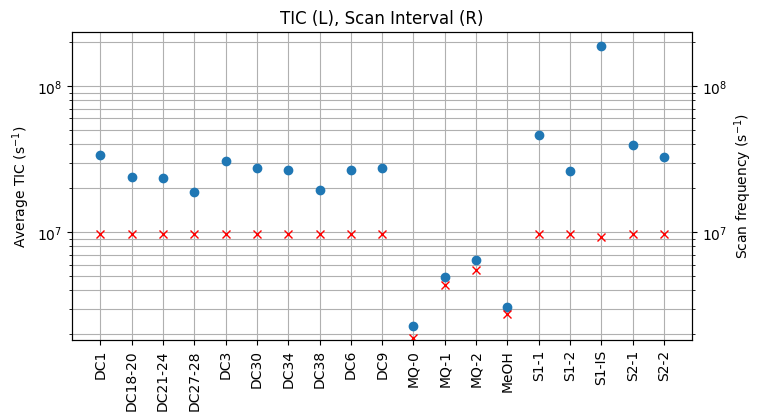

In [9]:
pd.set_option('display.float_format', '{:.2g}'.format)
TICs = summ[['sample_name','TIC_av']].groupby('sample_name').mean()
scandurs = summ[['sample_name','scan_dur_ms']].groupby('sample_name').mean()/1000

fig,ax=plt.subplots(figsize=[8,4])
ax.plot(TICs, lw=0, marker = 'o')
ax.set_yscale('log')
ax.set_ylabel('Average TIC (s$^{-1}$)')
plt.xticks(rotation=90);

ax2=ax.twinx()
ax2.plot(10e6/scandurs, lw=0, marker = 'x',c='r',ms=6)
ax2.set_ylabel('Scan frequency (s$^{-1}$)')
plt.xticks(rotation=90)
ax2.set_yscale('log')
ax2.set_ylim([ax.get_ylim()[0],ax.get_ylim()[1]])

ax.grid(axis='both',which='both')
ax.set_title('TIC (L), Scan Interval (R)')

### c. Check for outlying blocks

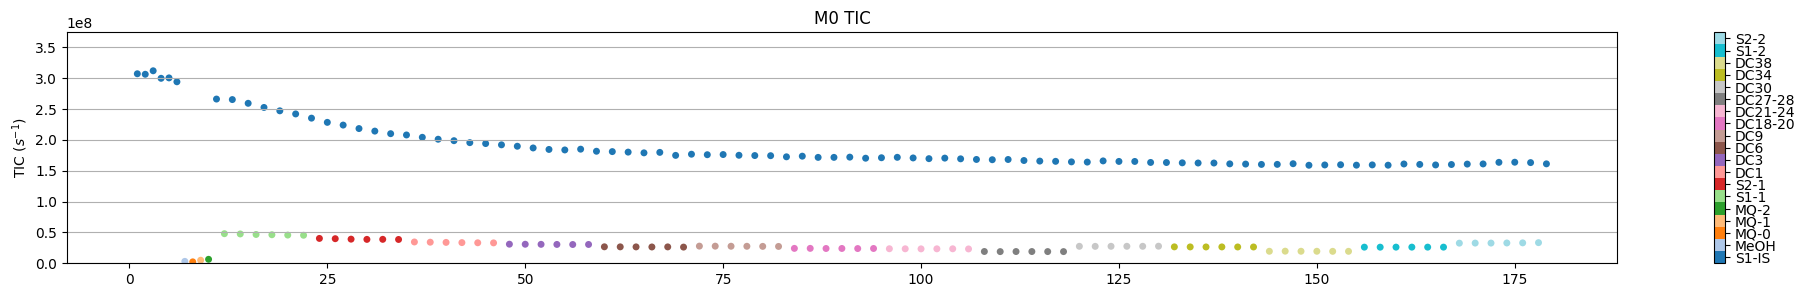

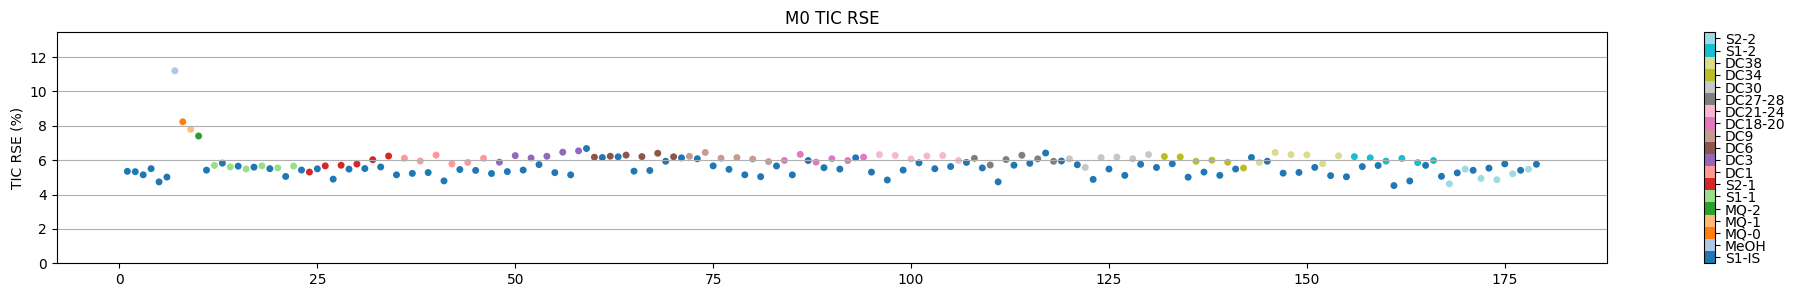

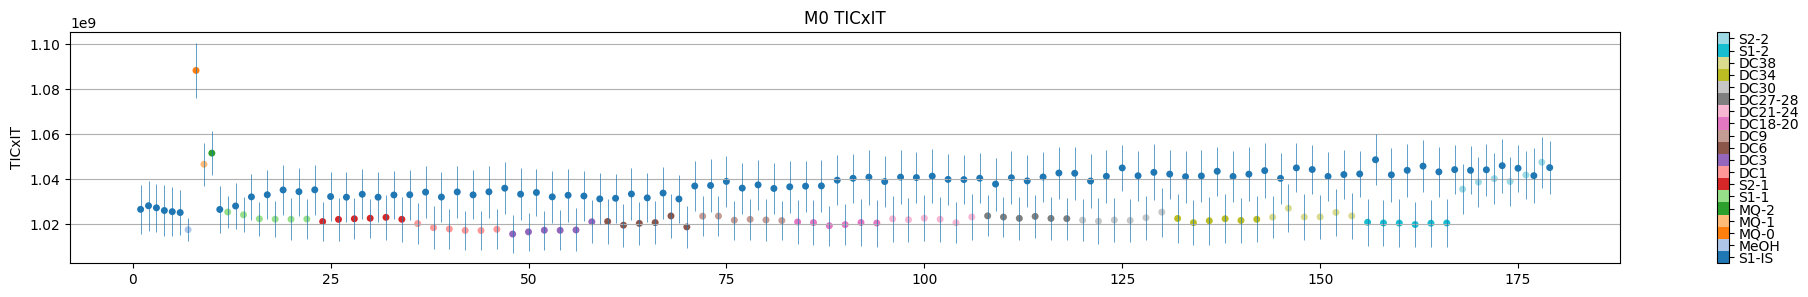

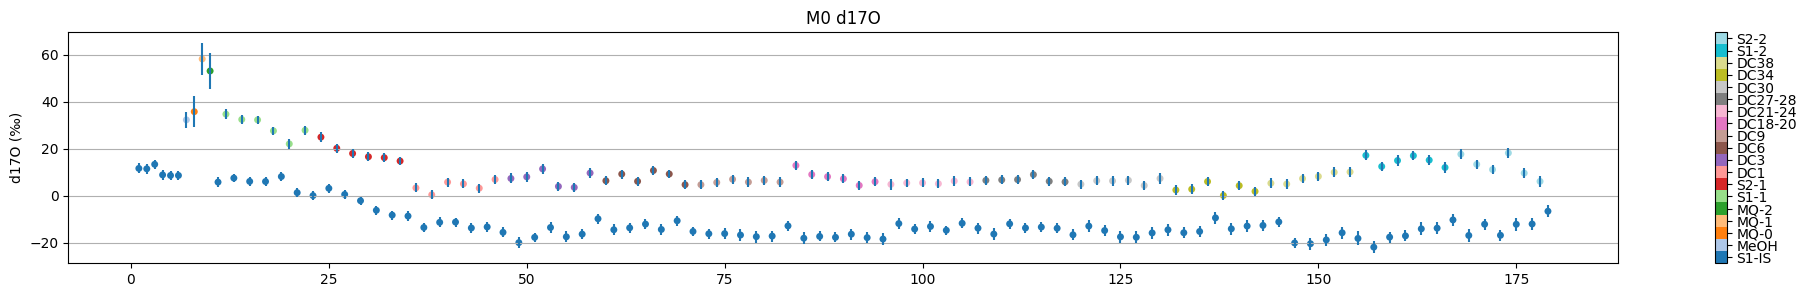

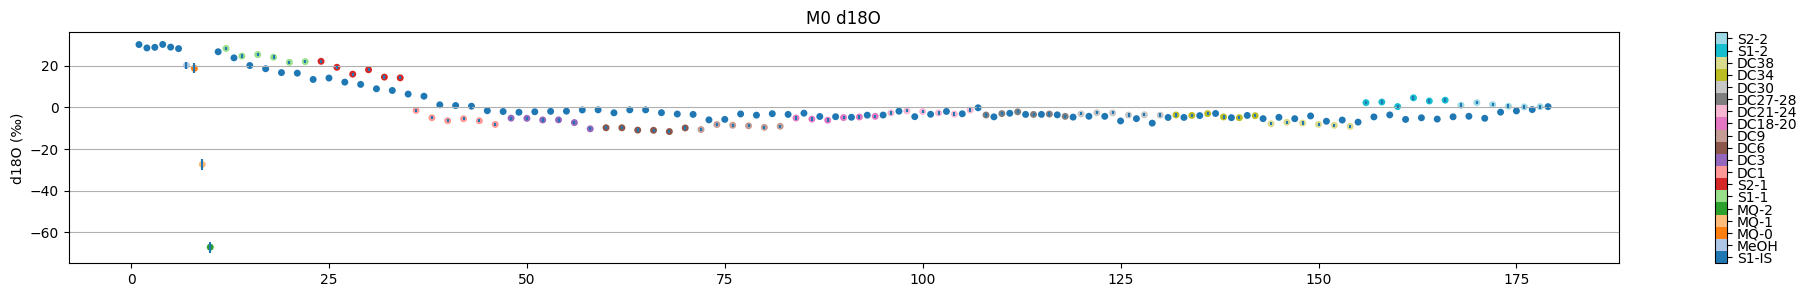

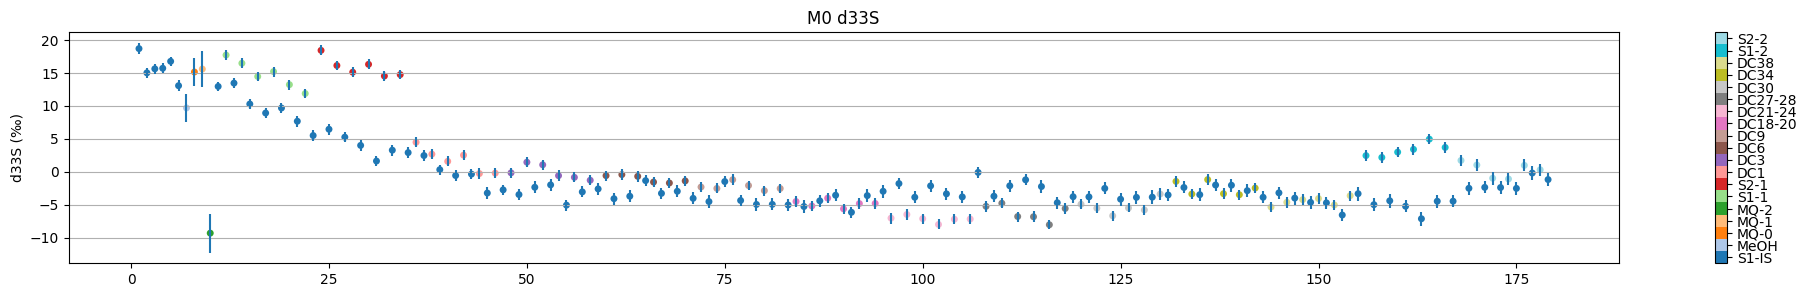

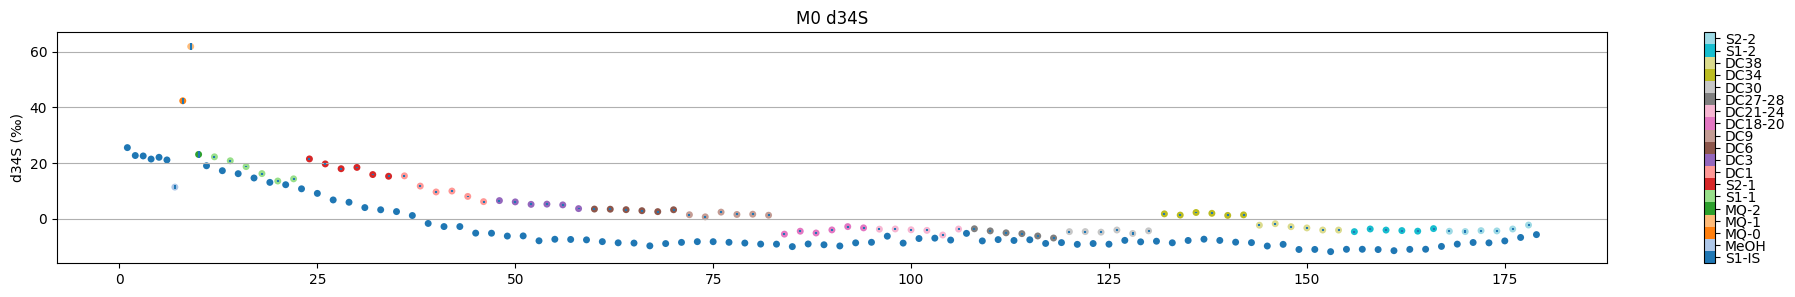

In [10]:
blocknames = summ.index
rcols = summ.columns[[col.startswith('ratio') for col in summ.columns]]

# identify M0 and/or noM0 experiments
exp_list = summ['basepeak'].unique()
for i,bp in enumerate(exp_list):
    if bp!='M0':
        exp_list[i]='noM0'

# separate M0 and noM0 data
for k,bp in enumerate(summ['basepeak'].unique()):
    summ1 = summ[summ['basepeak']==bp]
    if bp!='M0':
        exp='noM0'
    else:
        exp='M0'
    
    # colour mapping
    categories = summ1['sample_name']
    from matplotlib.colors import ListedColormap
    tab10_cmap = plt.get_cmap('tab20')
    colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
    discrete_cmap = ListedColormap(colors)
    category_mapping = {category: i for i, category in enumerate(categories.unique())}
    numeric_categories = np.array([category_mapping[category] for category in categories])
    discrete_cmap = plt.colormaps.get_cmap('tab20')

    # TIC plot
    fig,ax=plt.subplots(figsize=[25,3])
    scatter = ax.scatter(summ1['sample_ID'], summ1['TIC_av'], c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=100)
    cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
    cbar.set_ticklabels(categories.unique())
    ax.grid(True, axis='y')
    ax.set_ylabel('TIC ($s^{-1}$)')
    ax.set_title(exp+' TIC')
    ax.set_ylim([0,1.2*max(summ1['TIC_av'])])
    
    # TIC RSE plot
    fig,ax=plt.subplots(figsize=[25,3])
    scatter = ax.scatter(summ1['sample_ID'], summ1['TIC_rse']*100, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=100)
    cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
    cbar.set_ticklabels(categories.unique())
    ax.grid(True, axis='y')
    ax.set_ylabel('TIC RSE (%)')
    ax.set_title(exp+' TIC RSE')
    ax.set_ylim([0,120*max(summ1['TIC_rse'])])
    
    # TICxIT plot
    fig,ax=plt.subplots(figsize=[25,3])
    scatter = ax.scatter(x=summ1['sample_ID'],  # x-values
                      y=summ1['TICxIT_av'],  # y-values
                      c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=100)
    ax.errorbar(x=summ1['sample_ID'], y=summ1['TICxIT_av'], yerr=summ1['TICxIT_std'], lw=0.5,ls='none',fmt='none')
    cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
    cbar.set_ticklabels(categories.unique())
    ax.grid(True, axis='y')
    ax.set_ylabel('TICxIT')
    ax.set_title(exp+' TICxIT')

    # isotopologue ratio plots
    for i,col in enumerate(rcols):
        # check for empty column
        if len(summ1[col].dropna())>1:
            fig,ax=plt.subplots(figsize=[25,3])
            scatter = ax.scatter(summ1['sample_ID'], (summ1[col]/summ1[col].mean()-1)*1000, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.', s=100)
            ax.errorbar(summ1['sample_ID'], (summ1[col]/summ1[col].mean()-1)*1000, yerr=(summ1['sem_'+col[6:]]/summ1[col])*1000, fmt='none')
            cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
            cbar.set_ticklabels(categories.unique())
            ax.grid(True, axis='y')
            ax.set_ylabel('d' + col.split('_')[-1] + ' (‰)')
            ax.set_title(exp+' d' + col.split('_')[-1])



### d. Plot TIC and rolling $\delta^{18}O$ for each block, check for outliers
Input: meandur (rolling mean duration in minutes)

<>:32: SyntaxWarning: invalid escape sequence '\d'
<>:32: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Thermo\AppData\Local\Temp\ipykernel_14720\1088345404.py:32: SyntaxWarning: invalid escape sequence '\d'
  ax[2].set_ylabel('$\delta^{18}O$ (‰)')


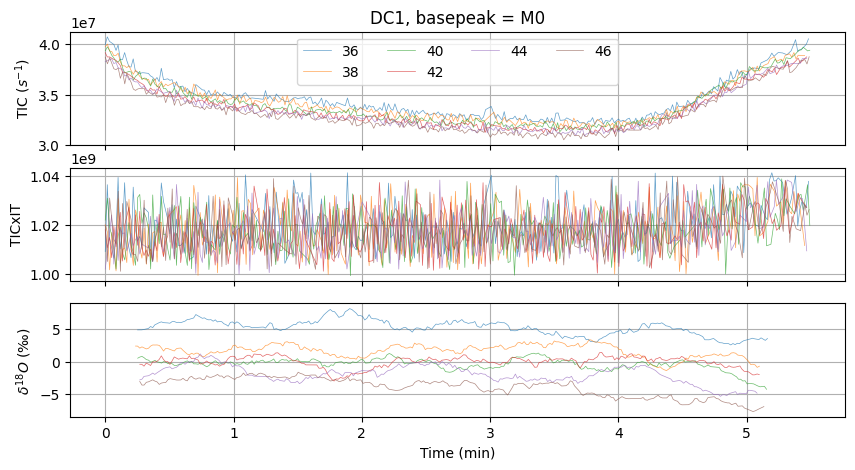

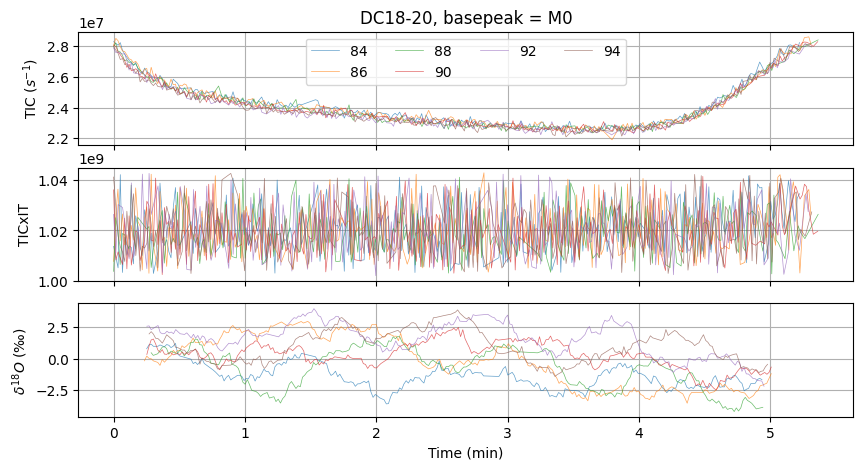

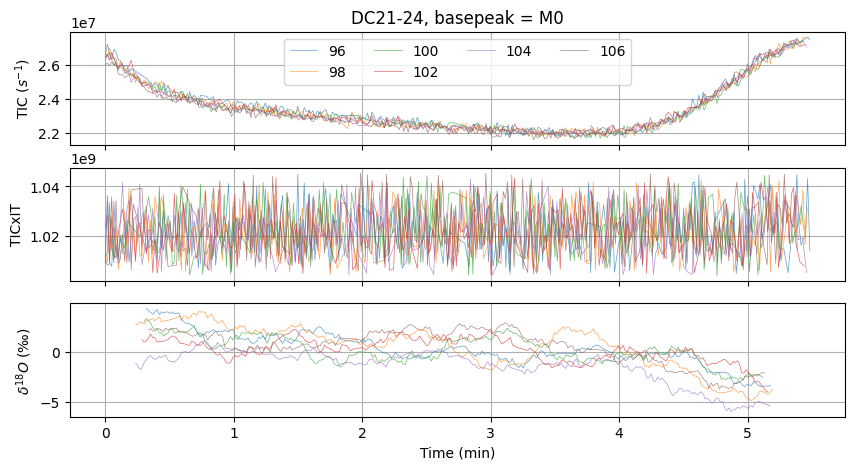

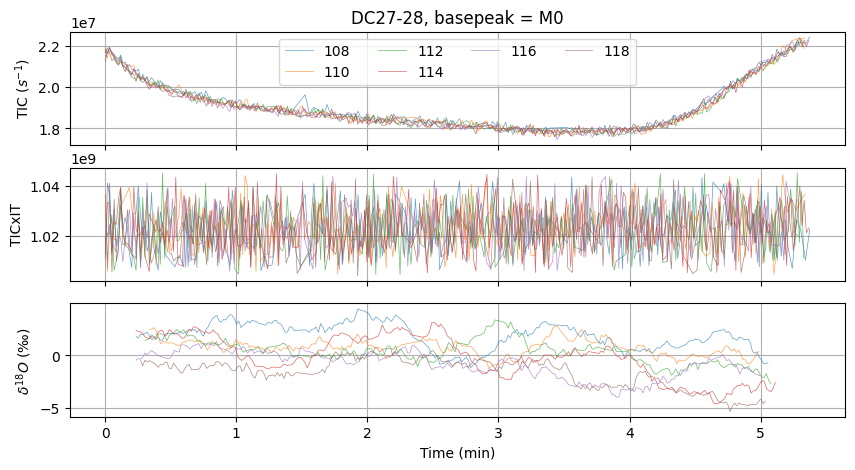

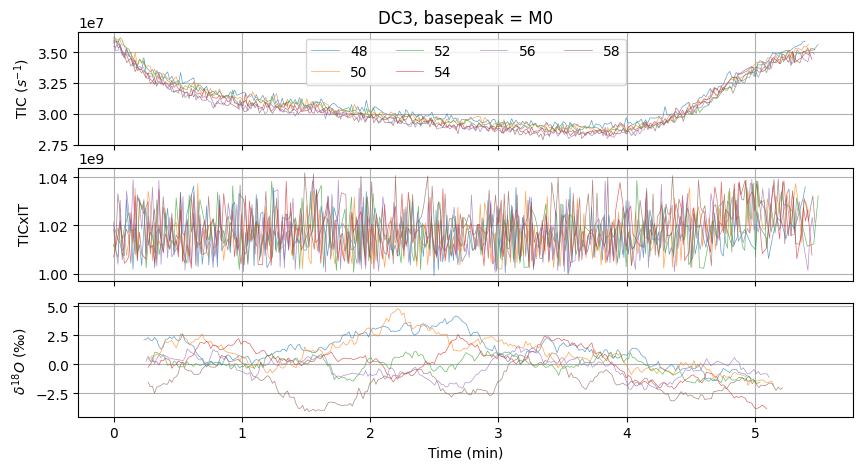

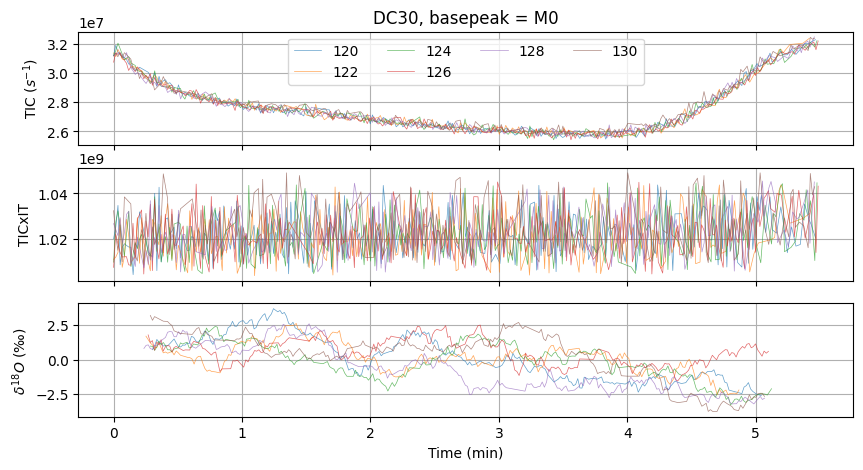

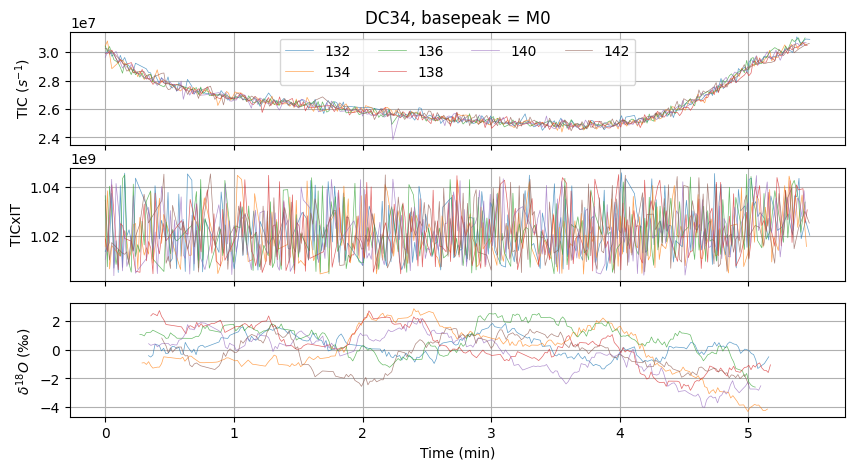

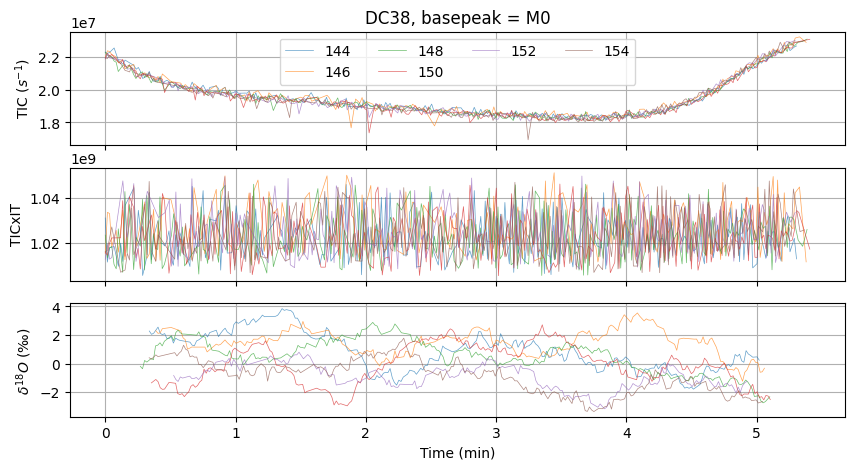

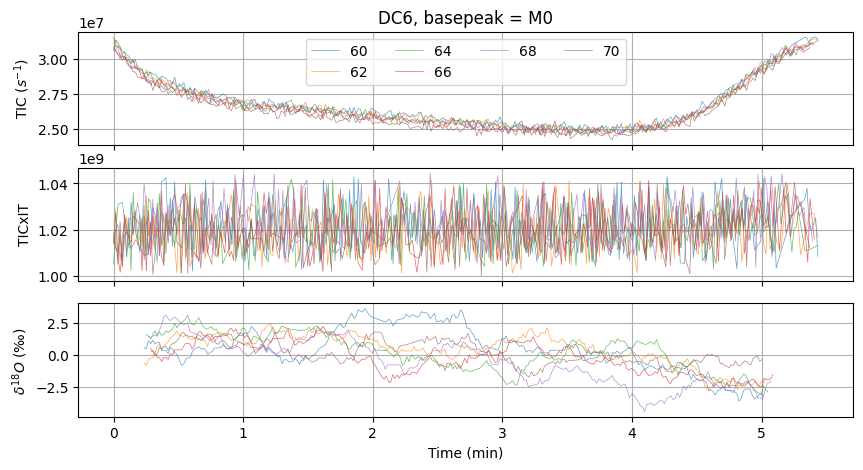

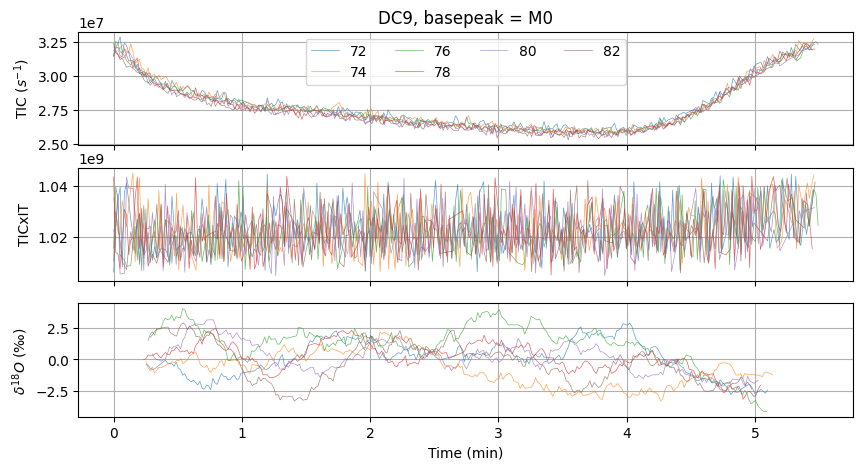

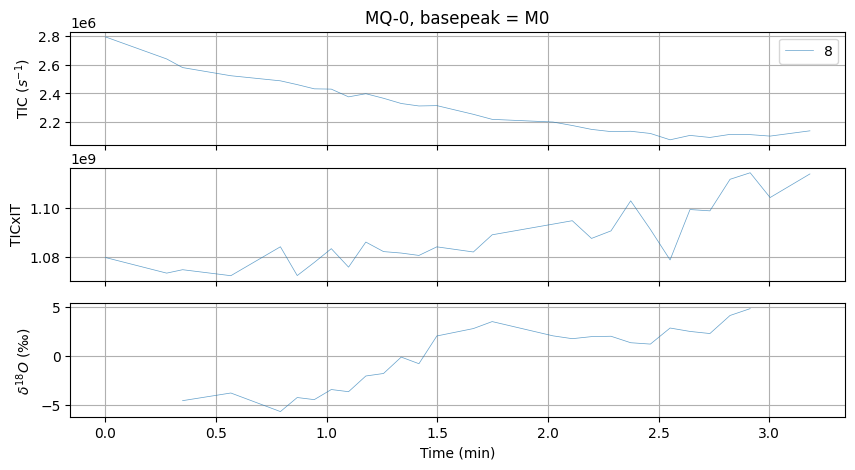

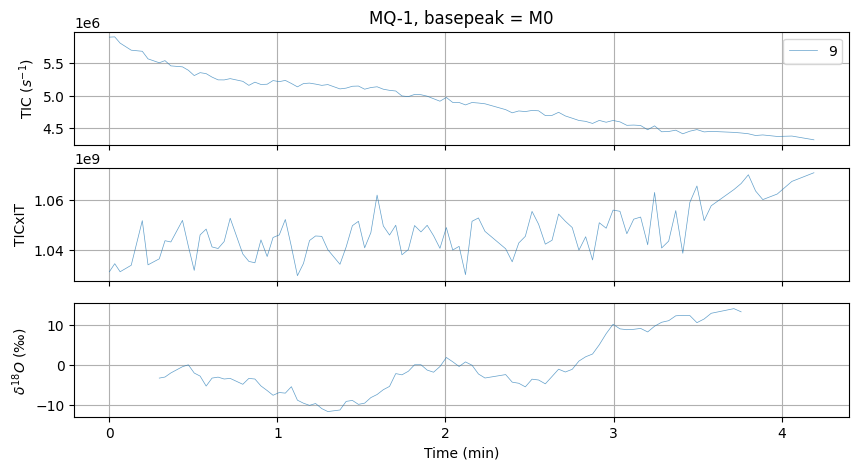

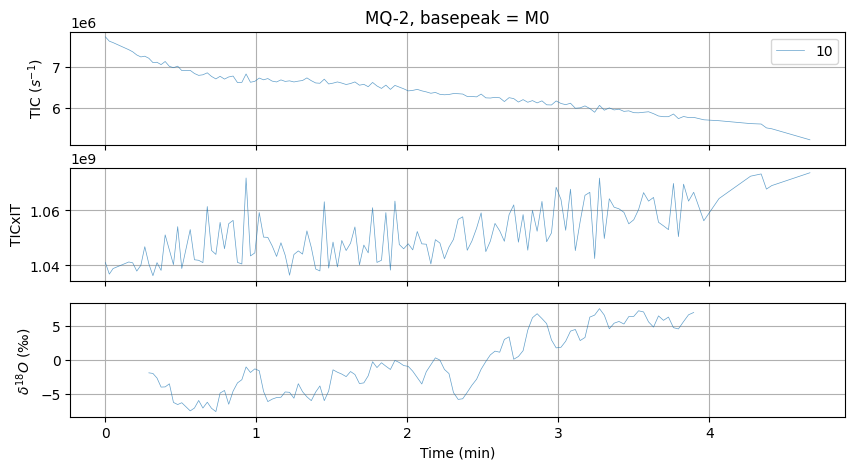

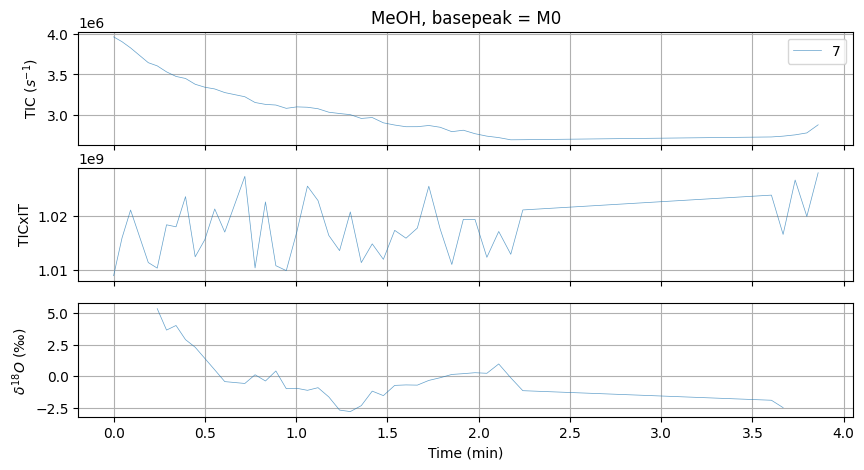

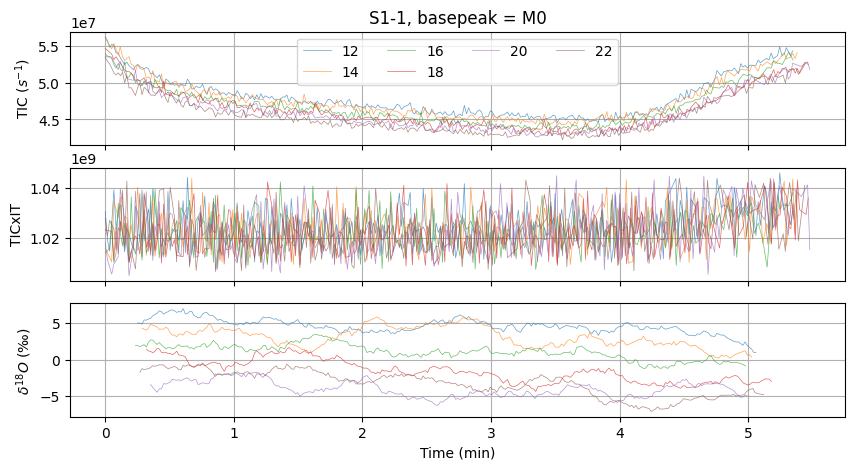

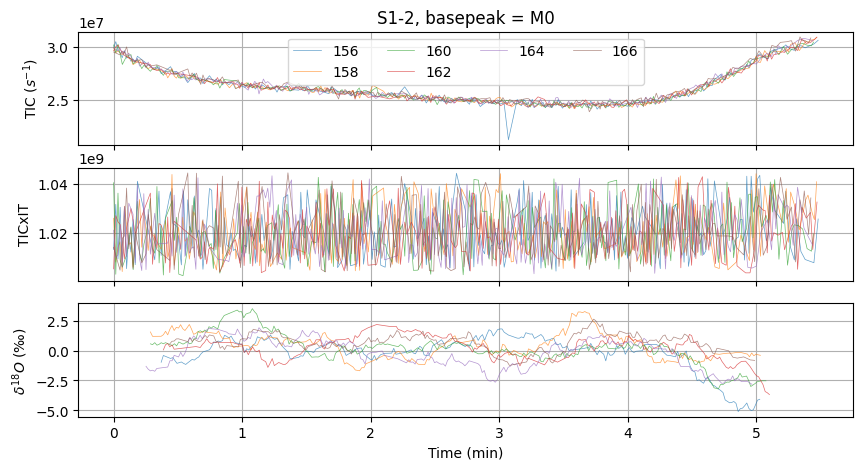

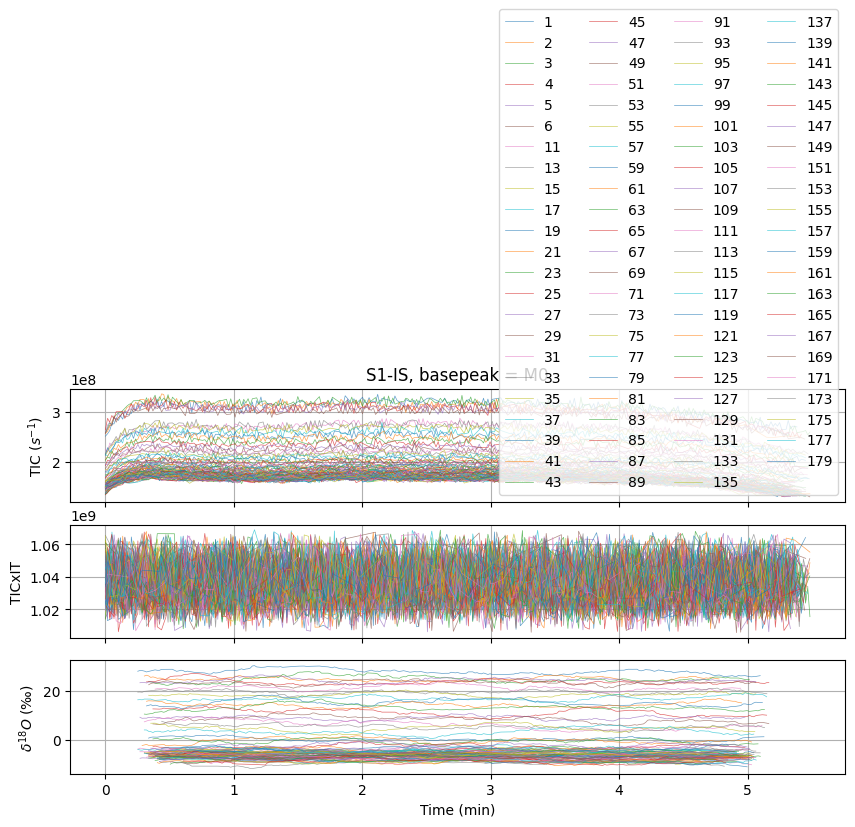

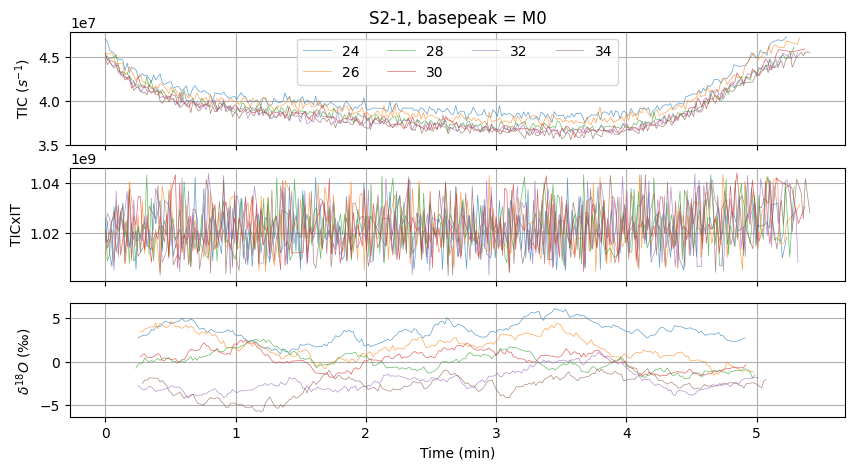

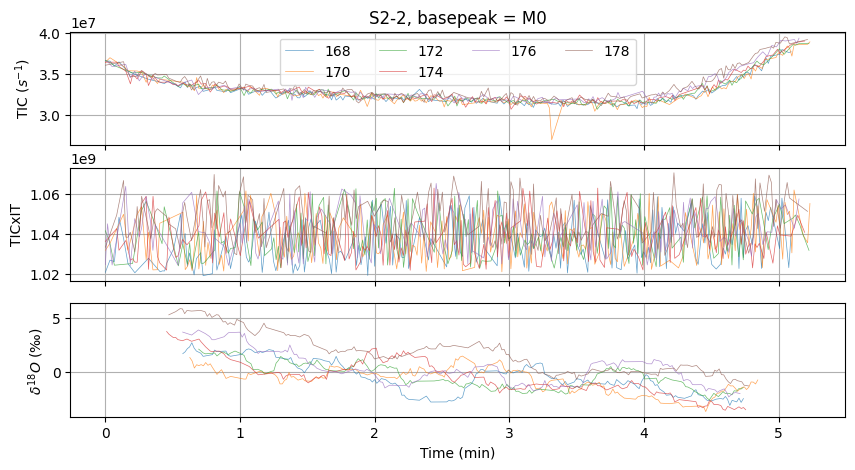

In [19]:
for (sample,basepeak), data_sb in data_compiled[data_compiled['isotopolog']=='34S'].groupby(['sample_name','basepeak']):
    
    fig,ax = plt.subplots(3, figsize = [10,5])
    ax[0].set_title(sample +', basepeak = '+basepeak)
    
    ref_18O = data_sb['ratio_to_basepeak'].mean()
                
    for sample_ID, data_sbi in data_sb.groupby('sample_ID'):
        
        scandur = data_sb['time.min'].diff().median()
        meandur = 0.5  # minutes for rolling mean calculation
        window_size = int(meandur / scandur)
        if basepeak=='M0':
            data_sbi['Rolling_18O'] = data_sbi['ratio_to_basepeak'].rolling(window=window_size, center=True).mean()
        else:
            data_sbi['Rolling_18O'] = data_sbi['ratio_to_basepeak'].rolling(window=int(window_size/2), center=True).mean()
                
        ax[0].plot(data_sbi['time.min']-data_sbi['time.min'].min(),data_sbi['tic'], label=sample_ID, lw=0.5,alpha=0.7)
        ax[0].grid(True,axis='both')
        ax[0].set_ylabel('TIC ($s^{-1}$)')
        ax[0].legend(ncols=4)        
        ax[0].set_xticklabels([])

        ax[1].plot(data_sbi['time.min']-data_sbi['time.min'].min(),data_sbi['tic']*data_sbi['it.ms'], label=sample_ID, lw=0.5,alpha=0.7)
        ax[1].grid(True,axis='both')
        ax[1].set_ylabel('TICxIT')   
        ax[1].set_xticklabels([])

        ax[2].plot(data_sbi['time.min']-data_sbi['time.min'].min(),1000*(data_sbi['Rolling_18O']/ref_18O-1), lw=0.5,alpha=0.7)
        ax[2].set_xlim(ax[0].get_xlim())
        ax[2].grid(True,axis='both')
        ax[2].set_ylabel('$\delta^{18}O$ (‰)')


        ax[-1].set_xlabel('Time (min)')

### e. Block filtering
Remove unfaithful injections using filters or by hand   
Saves a filtered summary file '_summary_filtered.csv'

In [20]:
print('List of the first occurence of each sample name')

summ.groupby('sample_name').first().sort_values('sample_ID')
# summ[['sample_name','experiment']]

List of the first occurence of each sample name


sample_ID    filename sample_type position   blockname compound  \
sample_name                                                                   
S1-IS               1  241018_001     Unknown     Y:F1  241018_001      SO4   
MeOH                7  241018_007     Unknown     Y:A1  241018_007      SO4   
MQ-0                8  241018_008     Unknown     Y:A2  241018_008      SO4   
MQ-1                9  241018_009     Unknown     Y:A3  241018_009      SO4   
MQ-2               10  241018_010     Unknown     Y:A4  241018_010      SO4   
S1-1               12  241018_012     Unknown     Y:A6  241018_012      SO4   
S2-1               24  241018_024     Unknown     Y:A7  241018_024      SO4   
DC1                36  241018_036     Unknown     Y:A8  241018_036      SO4   
DC3                48  241018_048     Unknown     Y:A9  241018_048      SO4   
DC6                60  241018_060     Unknown     Y:B1  241018_060      SO4   
DC9                72  241018_072     Unknown     Y:B2  241018_072      SO4   
DC18-20            84  241018_084     Unknown     Y:B3  241018_084      SO4   
DC21-24            96  241018_096     Unknown     Y:B4  241018_096      SO4   
DC27-28           108  241018_108     Unknown     Y:B5  241018_108      SO4   
DC30              120  241018_120     Unknown     Y:B6  241018_120      SO4   
DC34              132  241018_132     Unknown     Y:B7  241018_132      SO4   
DC38              144  241018_144     Unknown     Y:B8  241018_144      SO4   
S1-2              156  241018_156     Unknown     Y:B9  241018_156      SO4   
S2-2              168  241018_168     Unknown     Y:C1  241018_168      SO4   

            basepeak ratio_17O ratio_18O ratio_33S  ... stop_t_min scans  \
sample_name                                         ...                    
S1-IS             M0    0.0015    0.0088    0.0086  ...        5.9   247   
MeOH              M0    0.0016    0.0088    0.0085  ...        5.9    43   
MQ-0              M0    0.0016    0.0087    0.0085  ...        5.1    29   
MQ-1              M0    0.0016    0.0083    0.0086  ...        5.4    96   
MQ-2              M0    0.0016     0.008    0.0083  ...        5.7   135   
S1-1              M0    0.0016    0.0088    0.0086  ...          6   297   
S2-1              M0    0.0016    0.0088    0.0086  ...        5.7   280   
DC1               M0    0.0015    0.0086    0.0085  ...          6   295   
DC3               M0    0.0015    0.0085    0.0084  ...          6   286   
DC6               M0    0.0015    0.0085    0.0084  ...        5.9   280   
DC9               M0    0.0015    0.0085    0.0084  ...          6   287   
DC18-20           M0    0.0015    0.0085    0.0084  ...        5.7   273   
DC21-24           M0    0.0015    0.0086    0.0084  ...          6   271   
DC27-28           M0    0.0015    0.0085    0.0084  ...        5.9   277   
DC30              M0    0.0015    0.0086    0.0084  ...          6   277   
DC34              M0    0.0015    0.0085    0.0084  ...          6   249   
DC38              M0    0.0015    0.0085    0.0084  ...        5.8   270   
S1-2              M0    0.0015    0.0086    0.0084  ...          6   248   
S2-2              M0    0.0015    0.0086    0.0084  ...        5.6   203   

             TIC_av TIC_rse TICxIT_av TICxIT_std integration_t_ms scan_dur_ms  \
sample_name                                                                     
S1-IS       3.1e+08   0.054     1e+09    1.1e+07              3.4       1e+03   
MeOH        3.1e+06    0.11     1e+09    5.2e+06          3.3e+02     3.6e+03   
MQ-0        2.3e+06   0.082   1.1e+09    1.2e+07          4.8e+02     5.3e+03   
MQ-1        4.9e+06   0.078     1e+09    9.4e+06          2.1e+02     2.3e+03   
MQ-2        6.4e+06   0.074   1.1e+09    9.7e+06          1.6e+02     1.8e+03   
S1-1        4.8e+07   0.057     1e+09    7.1e+06               21       1e+03   
S2-1          4e+07   0.053     1e+09    8.7e+06               25       1e+03   
DC1         3.5e+07   0.06

In [21]:
# filter blocks using to_remove.csv
to_remove_filtering=False
# filter blocks manually using code below
manual_filtering=True

summ['to_remove'] = False

# load samples to remove from file
if os.path.exists(os.path.join(pathresults,'to_remove.csv'))&to_remove_filtering==True:
    to_remove = pd.read_csv(os.path.join(pathresults,'to_remove.csv'),index_col='blockname')

    for i,block in enumerate(summ['blockname']):
        if block not in to_remove.index:
            print(block, 'not found in to_remove')
        elif to_remove.loc[block,'to_remove']==True:
            summ['to_remove'] = summ['to_remove']|(summ['blockname']==block)
            print(block, 'removed using to_remove')
    
# specify files to remove manually
if manual_filtering==True:
    # blank filter
    if True:
        summ['to_remove'] = summ['to_remove']|(summ['sample_name'].str.startswith('MQ'))|(summ['sample_name'].str.startswith('MeOH'))
        print('Removed '+str(len(summ[summ['to_remove']])) + ' blank blocks: \n'+ str(list(summ[summ['to_remove']]['blockname'])))

    # minimum TIC filter
    if True:
        minTIC=1e5
        summ['to_remove'] = summ['to_remove']|(summ['TIC_av']<minTIC)
        print('\nRemoved '+str(len(summ[summ['TIC_av']<minTIC])) + ' further blocks with low TIC \n'+ str(list(summ[summ['TIC_av']<minTIC]['blockname'])))

    # TICxIT filter
    if True:
        minTICIT=summ['TICxIT_av'].median()*0.98
        maxTICIT=summ['TICxIT_av'].median()*1.02
        summ['to_remove'] = summ['to_remove']|((summ['TICxIT_av']<minTICIT) | (summ['TICxIT_av']>maxTICIT))
        print('\nRemoved '+str(len(summ[(summ['TICxIT_av']<minTICIT) | (summ['TICxIT_av']>maxTICIT)])) + ' further blocks with outlying TICxIT \n'+ str(list(summ[(summ['TICxIT_av']<minTICIT) | (summ['TICxIT_av']>maxTICIT)]['blockname'])))

    # Other injection numbers to remove by sample ID or name
    remove = []
    remove_blockname = []
    remove_samplename = ['USGS34_2','NICO6_2']
    summ['to_remove'] = summ['to_remove']|(summ['sample_ID'].isin(remove))|(summ['blockname'].isin(remove_blockname))|(summ['sample_name'].isin(remove_samplename))
    print('\nRemoved '+str(len(summ[(summ.index.isin(remove))|(summ['blockname'].isin(remove_blockname))])) + ' addional blocks: \n'+ str(list(summ[(summ.index.isin(remove))|(summ['blockname'].isin(remove_blockname))]['blockname'])))

# remove labelled blocks
summ_filt = summ[summ['to_remove']==False].reset_index(drop=True)

# sort to seperate m0 and no-m0 data for bracketing
summ_filt = pd.concat([summ_filt[summ_filt['basepeak']=='M0'],summ_filt[summ_filt['basepeak']!='M0']]).reset_index(drop=True)
print('\nSeperated M0 and noM0 data:\n',
      summ_filt[['sample_name','blockname','basepeak']].head(10),
      '\n',summ_filt[['sample_name','blockname','basepeak']].tail(10))

# export summary files as csv  
summ[['blockname','to_remove']].to_csv(os.path.join(pathresults,'to_remove.csv'))
summ_filt.to_csv(os.path.join(pathresults,'summary_filtered.csv'))
summ.to_csv(os.path.join(pathresults,'summary_nonfiltered.csv'))
print('\nSaved unfiltered summary file as ' + os.path.join(pathresults,'summary_nonfiltered.csv.'))
print('Saved filtering list as ' + os.path.join(pathresults,'to_remove.csv.'))
print('Saved filtered summary file as ' + os.path.join(pathresults,'summary_filtered.csv.'))
print('\nRemoved blocks:')
summ[summ['to_remove']==True]

Removed 4 blank blocks: 
['241018_007', '241018_008', '241018_009', '241018_010']

Removed 0 further blocks with low TIC 
[]

Removed 1 further blocks with outlying TICxIT 
['241018_008']

Removed 0 addional blocks: 
[]

Seperated M0 and noM0 data:
   sample_name   blockname basepeak
0       S1-IS  241018_001       M0
1       S1-IS  241018_002       M0
2       S1-IS  241018_003       M0
3       S1-IS  241018_004       M0
4       S1-IS  241018_005       M0
5       S1-IS  241018_006       M0
6       S1-IS  241018_011       M0
7        S1-1  241018_012       M0
8       S1-IS  241018_013       M0
9        S1-1  241018_014       M0 
     sample_name   blockname basepeak
165        S2-2  241018_170       M0
166       S1-IS  241018_171       M0
167        S2-2  241018_172       M0
168       S1-IS  241018_173       M0
169        S2-2  241018_174       M0
170       S1-IS  241018_175       M0
171        S2-2  241018_176       M0
172       S1-IS  241018_177       M0
173        S2-2  241018_178   

sample_ID    filename sample_type sample_name position   blockname  \
blockname                                                                       
241018_007         7  241018_007     Unknown        MeOH     Y:A1  241018_007   
241018_008         8  241018_008     Unknown        MQ-0     Y:A2  241018_008   
241018_009         9  241018_009     Unknown        MQ-1     Y:A3  241018_009   
241018_010        10  241018_010     Unknown        MQ-2     Y:A4  241018_010   

           compound basepeak ratio_17O ratio_18O  ... scans  TIC_av TIC_rse  \
blockname                                         ...                         
241018_007      SO4       M0    0.0016    0.0088  ...    43 3.1e+06    0.11   
241018_008      SO4       M0    0.0016    0.0087  ...    29 2.3e+06   0.082   
241018_009      SO4       M0    0.0016    0.0083  ...    96 4.9e+06   0.078   
241018_010      SO4       M0    0.0016     0.008  ...   135 6.4e+06   0.074   

           TICxIT_av TICxIT_std integration_t_ms scan_dur_ms analyser_temp  \
blockname                                                                    
241018_007     1e+09    5.2e+06          3.3e+02     3.6e+03            34   
241018_008   1.1e+09    1.2e+07          4.8e+02     5.3e+03            34   
241018_009     1e+09    9.4e+06          2.1e+02     2.3e+03            34   
241018_010   1.1e+09    9.7e+06          1.6e+02     1.8e+03            34   

           notes to_remove  
blockname                   
241018_007            True  
241018_008            True  
241018_009            True  
241018_010            True  

[4 rows x 28 columns]

Text(0.5, 1.0, 'M0 TICxIT')

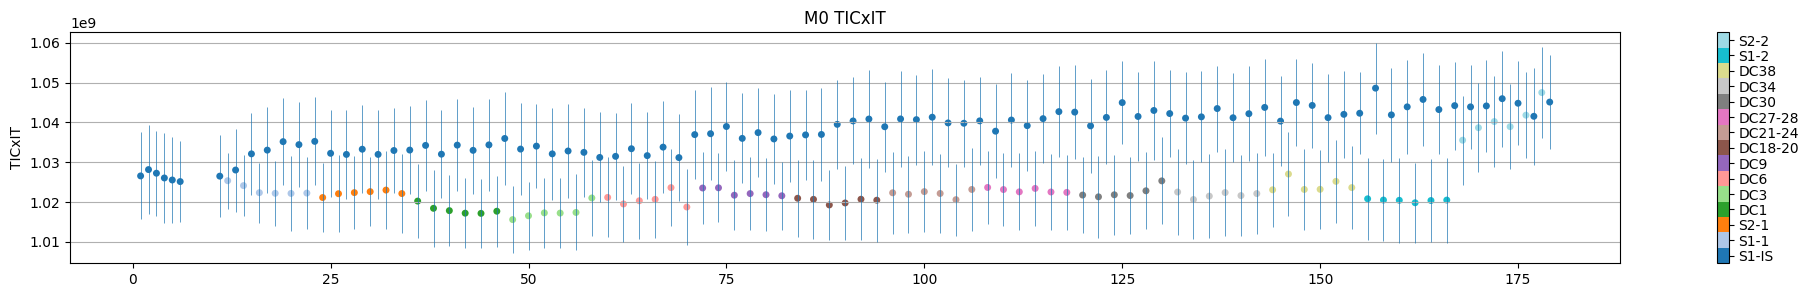

In [22]:
# plot after filtering
# colour mapping
categories = summ_filt['sample_name']
from matplotlib.colors import ListedColormap
tab10_cmap = plt.get_cmap('tab20')
colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
discrete_cmap = ListedColormap(colors)
category_mapping = {category: i for i, category in enumerate(categories.unique())}
numeric_categories = np.array([category_mapping[category] for category in categories])
discrete_cmap = plt.colormaps.get_cmap('tab20')

# TICxIT plot
fig,ax=plt.subplots(figsize=[25,3])
scatter = ax.scatter(x=summ_filt['sample_ID'],  # x-values
                  y=summ_filt['TICxIT_av'],  # y-values
                  c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=100)
ax.errorbar(x=summ_filt['sample_ID'], y=summ_filt['TICxIT_av'], yerr=summ_filt['TICxIT_std'], lw=0.5,ls='none',fmt='none')
cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
cbar.set_ticklabels(categories.unique())
ax.grid(True, axis='y')
ax.set_ylabel('TICxIT')
ax.set_title(exp+' TICxIT')

## 3. Calculation of delta values
### a. Bracketing
Uses brackting formula: $\delta = \frac{2R_i}{R_{i-1}+R_{i+1}}-1$ to calculate internal deltas for each isotopologue for every sample which is surrounded by internal standards.  
- Saves internal deltas as 'internal_deltas_YYYY-MM-DD.csv'.  
- Saves summary as 'internal_deltas_summary_YYYY-MM-DD.csv' with mean and sem for each isotopologue for each sample.


<>:107: SyntaxWarning: invalid escape sequence '\d'
<>:108: SyntaxWarning: invalid escape sequence '\d'
<>:107: SyntaxWarning: invalid escape sequence '\d'
<>:108: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Thermo\AppData\Local\Temp\ipykernel_14720\2999290422.py:107: SyntaxWarning: invalid escape sequence '\d'
  ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
C:\Users\Thermo\AppData\Local\Temp\ipykernel_14720\2999290422.py:108: SyntaxWarning: invalid escape sequence '\d'
  ax[i].set_title('Internal $\delta' + iso +'$ relative to '+int_std+' base-peak (not blank-corrected)')


Internal standard manually selected: S1-IS
Bracketed internal delta values relative to basepeak saved as results_2024-10-23\internal_deltas_2024-10-23.csv
Summarised ouptut saved as results_2024-10-23\internal_deltas_summary_2024-10-23.csv


sample_type position basepeak         rel_to  scans_sample  \
sample_name                                                              
S1-1            Unknown     Y:A6       M0  S1-IS M0 peak          1747   
S2-1            Unknown     Y:A7       M0  S1-IS M0 peak          1715   
DC1             Unknown     Y:A8       M0  S1-IS M0 peak          1759   
DC3             Unknown     Y:A9       M0  S1-IS M0 peak          1737   
DC6             Unknown     Y:B1       M0  S1-IS M0 peak          1682   
DC9             Unknown     Y:B2       M0  S1-IS M0 peak          1720   
DC18-20         Unknown     Y:B3       M0  S1-IS M0 peak          1618   
DC21-24         Unknown     Y:B4       M0  S1-IS M0 peak          1688   
DC27-28         Unknown     Y:B5       M0  S1-IS M0 peak          1667   
DC30            Unknown     Y:B6       M0  S1-IS M0 peak          1605   
DC34            Unknown     Y:B7       M0  S1-IS M0 peak          1520   
DC38            Unknown     Y:B8       M0  S1-IS M0 peak          1535   
S1-2            Unknown     Y:B9       M0  S1-IS M0 peak          1502   
S2-2            Unknown     Y:C1       M0  S1-IS M0 peak          1221   

            scans_std mean_d17O mean_d18O mean_d33S mean_d34S  ... err_d18O  \
sample_name                                                    ...            
S1-1         1.49e+03     24.09      4.97      4.91      2.89  ...     0.73   
S2-1         1.42e+03     21.42      6.59     11.69     12.09  ...     0.60   
DC1          1.37e+03     16.90     -6.92      2.01     12.26  ...     0.39   
DC3           1.3e+03     24.05     -4.85      3.05     12.26  ...     0.94   
DC6          1.23e+03     21.01     -8.34      2.06     11.95  ...     0.45   
DC9          1.16e+03     22.61     -5.00      1.89     10.16  ...     0.61   
DC18-20      1.12e+03     25.59     -1.17     -0.33      5.11  ...     0.43   
DC21-24      1.07e+03     19.42      0.51     -4.43      3.10  ...     0.43   
DC27-28       1.1e+03     21.27      0.07     -3.56      2.54  ...     0.41   
DC30              976     22.08      2.25     -1.66      4.01  ...     0.42   
DC34            1e+03     16.67      0.27      0.20      9.76  ...     0.44   
DC38            1e+03     25.08     -2.54     -0.04      7.45  ...     0.43   
S1-2              930     31.85      7.82      8.34      6.95  ...     0.70   
S2-2              936     26.17      3.74      2.46      4.22  ...     1.02   

            err_d33S err_d34S TIC_sample   TIC_std TIC_RSE_sample  \
sample_name                                                         
S1-1            0.38     0.48   4.66e+07  2.53e+08          56.13   
S2-1            0.50     0.30   3.92e+07  2.19e+08          57.88   
DC1             0.39     0.31   3.37e+07  1.99e+08          60.21   
DC3             0.40     0.23   3.07e+07  1.86e+08          62.52   
DC6             0.41     0.18   2.65e+07  1.79e+08          62.53   
DC9             0.41     0.27   2.76e+07  1.75e+08          61.54   
DC18-20         0.42     0.37    2.4e+07  1.72e+08          60.75   
DC21-24         0.41     0.38   2.34e+07   1.7e+08          61.94   
DC27-28         0.68     0.24    1.9e+07  1.67e+08          60.27   
DC30            0.50     0.26   2.75e+07  1.65e+08          60.67   
DC34            0.52     0.19   2.65e+07  1.62e+08          59.60   
DC38            0.48     0.19   1.95e+07   1.6e+08          61.67   
S1-2            0.66     0.19   2.61e+07   1.6e+08          60.38   
S2-2            0.66     0.21   3.29e+07  1.62e+08          50.98   

            TICxIT_sample TICxIT_std notes order  
sample_name                                       
S1-1             1.02e+09   1.03e+09           0  
S2-1             1.02e+09   1.03e+09           1  
DC1              1.02e+09   1.03e+09           2  
DC3              1.02e+09   1.03e+09           3  
DC6              1.02e+09   1.03e+09           4  
DC9              1.02e+09   1.04e+09           5  
DC18-20          1.02e+09   1.04e+09           6 

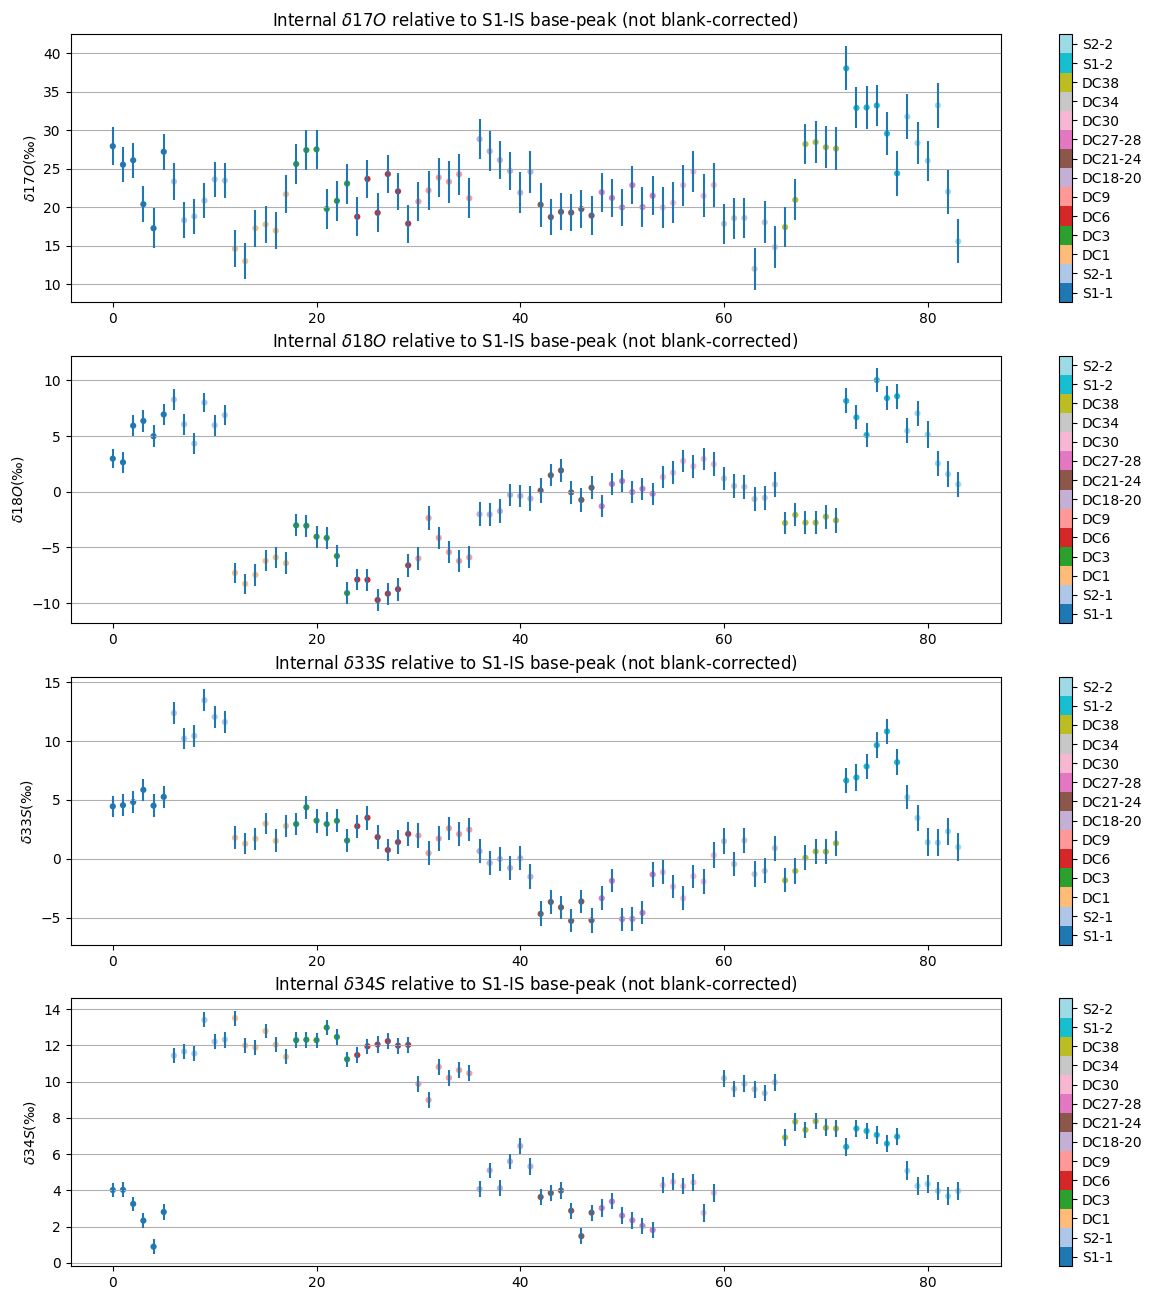

In [23]:
# identify internal standard
if len(summ_filt[summ_filt['sample_type']=='Internal standard']['sample_name'].unique())==1:
    int_std = summ_filt[summ_filt['sample_type']=='Internal standard']['sample_name'].iloc[0]
    print('Identified internal standard',int_std)
else:
    int_std = 'S1-IS'
    print("Internal standard manually selected:",int_std)
    

# identify isotopologs
isotopologues = [col.split('_')[1] for col in summ_filt.columns if col.split('_')[0]=='ratio']
    
# identify sample injections
samples = summ_filt[summ_filt['sample_name'] != int_std]
samples_delta = pd.DataFrame(columns=['sample_type','sample_name','position','blockname','basepeak']+['d'+iso for iso in isotopologues]+['err_d'+iso for iso in isotopologues]+['rel_to','TIC_sample','scans_sample','scans_std','notes'],index = samples.index)
samples_delta.loc[:,['sample_ID','sample_type','sample_name','position','blockname','basepeak','notes']]=samples.loc[:,['sample_ID','sample_type','sample_name','position','blockname','basepeak','notes']]


# bracketing
for i in samples.index:
    if i-1 in summ_filt.index and i+1 in summ_filt.index:
        if summ_filt.loc[i-1,'sample_name']== int_std and summ_filt.loc[i+1,'sample_name']==int_std:
            # calc delta
            R_i = summ_filt.loc[i,['ratio_'+iso for iso in isotopologues]]
            R_minus = summ_filt.loc[i-1,['ratio_'+iso for iso in isotopologues]]
            R_plus = summ_filt.loc[i+1,['ratio_'+iso for iso in isotopologues]]
            deltas = 2*R_i/(R_minus+R_plus)-1
            samples_delta.loc[i,['d'+iso for iso in isotopologues]] = deltas.tolist()
            # calc error
            e_i = summ_filt.loc[i,['sem_'+iso for iso in isotopologues]]
            e_minus = summ_filt.loc[i-1,['sem_'+iso for iso in isotopologues]]
            e_plus = summ_filt.loc[i+1,['sem_'+iso for iso in isotopologues]]
            err_d = e_i.copy()
            for sem_iso in e_i.index:
                err_d.loc[sem_iso] = ((2*e_i[sem_iso])**2 + e_minus[sem_iso]**2 + e_plus[sem_iso]**2)**0.5/(0.5*R_minus['ratio_'+sem_iso[4:]]+0.5*R_plus['ratio_'+sem_iso[4:]]+R_i['ratio_'+sem_iso[4:]])
            samples_delta.loc[i,['err_d'+iso for iso in isotopologues]] = err_d.tolist()
            
        samples_delta.loc[i,'rel_to'] = int_std+' '+samples_delta.loc[i,'basepeak']+' peak'
        samples_delta.loc[i,'TIC_sample']=summ_filt.loc[i,'TIC_av']
        samples_delta.loc[i,'TIC_std']=0.5*(summ_filt.loc[i-1,'TIC_av']+summ_filt.loc[i+1,'TIC_av'])
        samples_delta.loc[i,'TIC_RSE_sample']=summ_filt.loc[i,'TIC_rse']
        samples_delta.loc[i,'TICxIT_sample']=summ_filt.loc[i,'TICxIT_av']
        samples_delta.loc[i,'TICxIT_std']=0.5*(summ_filt.loc[i-1,'TICxIT_av']+summ_filt.loc[i+1,'TICxIT_av'])        
        samples_delta.loc[i,'scans_sample']=summ_filt.loc[i,'scans']
        samples_delta.loc[i,'scans_std']=0.5*(summ_filt.loc[i-1,'scans']+summ_filt.loc[i+1,'scans'])
        samples_delta.loc[i,'notes']=summ_filt.loc[i,'notes']
samples_delta.dropna(how='all',subset=['d'+iso for iso in isotopologues],inplace=True)
samples_delta.reset_index(inplace=True,drop=True)

# save
samples_delta.to_csv(os.path.join(pathresults,'internal_deltas_'+current_date_string+'.csv'))
print('Bracketed internal delta values relative to basepeak saved as '+ os.path.join(pathresults,'internal_deltas_'+current_date_string+'.csv'))

# summarise internal deltas per sample/experiment combo
stats=pd.DataFrame()
stats['sample_ID']=samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['sample_ID']
stats['sample_name']=samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['sample_name']
stats['sample_type']=samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['sample_type']
stats['position']=samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['position']
stats['basepeak']=samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['basepeak']
stats['rel_to']=samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['rel_to']
stats['scans_sample']=samples_delta.groupby(['sample_name','basepeak']).sum().reset_index()['scans_sample']
stats['scans_std']=samples_delta.groupby(['sample_name','basepeak']).sum().reset_index()['scans_std']
# mean delta
stats[['mean_d'+iso for iso in isotopologues]]=samples_delta.groupby(['sample_name','basepeak'])[['d'+iso for iso in isotopologues]].mean().reset_index()[['d'+iso for iso in isotopologues]]
# sem of N injections
sem=samples_delta.groupby(['sample_name','basepeak'])[['d'+iso for iso in isotopologues]].sem().reset_index()[['d'+iso for iso in isotopologues]]
# propogated error = sqrt(sum(err^2)/N))
def add_in_quadrature(errors):
    N = len(errors)
    return (np.sum(errors**2,axis=0)**0.5/N)
errprop = samples_delta.groupby(['sample_name','basepeak'])[['err_d'+iso for iso in isotopologues]].apply(add_in_quadrature).reset_index()[['err_d'+iso for iso in isotopologues]]
# select the grater error val
sem.columns = errprop.columns
stats[['err_d'+iso for iso in isotopologues]] = np.fmax(errprop,sem)

stats['TIC_sample'] = samples_delta.groupby(['sample_name','basepeak'])['TIC_sample'].mean().reset_index()['TIC_sample']
stats['TIC_std'] = samples_delta.groupby(['sample_name','basepeak'])['TIC_std'].mean().reset_index()['TIC_std']
stats['TIC_RSE_sample'] = samples_delta.groupby(['sample_name','basepeak'])['TIC_RSE_sample'].mean().reset_index()['TIC_RSE_sample']
stats['TICxIT_sample'] = samples_delta.groupby(['sample_name','basepeak'])['TICxIT_sample'].mean().reset_index()['TICxIT_sample']
stats['TICxIT_std'] = samples_delta.groupby(['sample_name','basepeak'])['TICxIT_std'].mean().reset_index()['TICxIT_std']
stats['notes'] = samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['notes']
# sort, put sample name as index
stats = stats.sort_values('sample_ID').reset_index(drop=True)
stats['order']=stats.index
stats.index=stats['sample_name']
stats.drop(['sample_name','sample_ID'],axis=1,inplace=True)

# plot
if True:
    fig,ax = plt.subplots(len(isotopologues), figsize=[15,4*len(isotopologues)])

    categories = samples_delta['sample_name']
    from matplotlib.colors import ListedColormap
    tab10_cmap = plt.get_cmap('tab20')
    colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
    discrete_cmap = ListedColormap(colors)
    category_mapping = {category: i for i, category in enumerate(categories.unique())}
    numeric_categories = np.array([category_mapping[category] for category in categories])

    for i,iso in enumerate(isotopologues):
        scatter = ax[i].scatter(samples_delta.index, samples_delta['d'+iso]*1000, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=80)
        ax[i].errorbar(samples_delta.index, samples_delta['d'+iso]*1000, yerr=samples_delta['err_d'+iso]*1000, fmt='none')
        cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories)) + 1) - 0.5)
        cbar.set_ticklabels(categories.unique())
        ax[i].grid(True, axis='y')
        ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
        ax[i].set_title('Internal $\delta' + iso +'$ relative to '+int_std+' base-peak (not blank-corrected)')
        # ax[i].set_xticks([])

        
# save
stats.to_csv(os.path.join(pathresults,'internal_deltas_summary_'+current_date_string+'.csv'))
print('Summarised ouptut saved as '+os.path.join(pathresults,'internal_deltas_summary_'+current_date_string+'.csv'))


# function to multiply only deltas by 1e3
def multiply_numerical(x):
    if isinstance(x,float):
        if abs(x)<1:
            return '{:.2f}'.format(x * 1e3)
        else:
            return '{:.3g}'.format(x)
    else:
        return x
# display
stats.map(multiply_numerical).head(20)

### b. Conversion of internal deltas to international scale based on values of internal standard
Reference delta values of internal standard are taken from the reference data (inputs at top of script).  

Saves external deltas:
- Saves external deltas as 'external_deltas_YYYY-MM-DD.csv'.
- Saves summary as 'external_deltas_summary_YYYY-MM-DD.csv' with mean and sem for each isotopologue for each sample.


<>:63: SyntaxWarning: invalid escape sequence '\d'
<>:64: SyntaxWarning: invalid escape sequence '\d'
<>:63: SyntaxWarning: invalid escape sequence '\d'
<>:64: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Thermo\AppData\Local\Temp\ipykernel_14720\669997740.py:63: SyntaxWarning: invalid escape sequence '\d'
  ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
C:\Users\Thermo\AppData\Local\Temp\ipykernel_14720\669997740.py:64: SyntaxWarning: invalid escape sequence '\d'
  ax[i].set_title('External $\delta' + iso +'$')
C:\Users\Thermo\AppData\Local\Temp\ipykernel_14720\669997740.py:63: SyntaxWarning: invalid escape sequence '\d'
  ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
C:\Users\Thermo\AppData\Local\Temp\ipykernel_14720\669997740.py:64: SyntaxWarning: invalid escape sequence '\d'
  ax[i].set_title('External $\delta' + iso +'$')


Imported reference data for internal standard S1 from references_sulphate.xlsx
mean_d33S            0.015
mean_d34S             0.01
mean_d36S             0.02
mean_d17O           0.0036
mean_d18O          0.00052
mean_d33S/34S       0.0045
mean_d17O/34S      -0.0066
mean_d18O/34S      -0.0096
mean_d36S/34S       0.0092
mean_d34S18O/34S   0.00052
mean_d33S18O/34S     0.005
mean_d34S17O/34S    0.0036
mean_d18O18O/34S   -0.0091
Name: S1, dtype: float64
Changed reference of internal deltas to international reference scale. 
Summarised output saved as results_2024-10-23\external_deltas_2024-10-23.csv


ValueError: Incorrect use of keyword argument 'rotation'. Keyword arguments other than 'minor' modify the text labels and can only be used if 'labels' are passed as well.

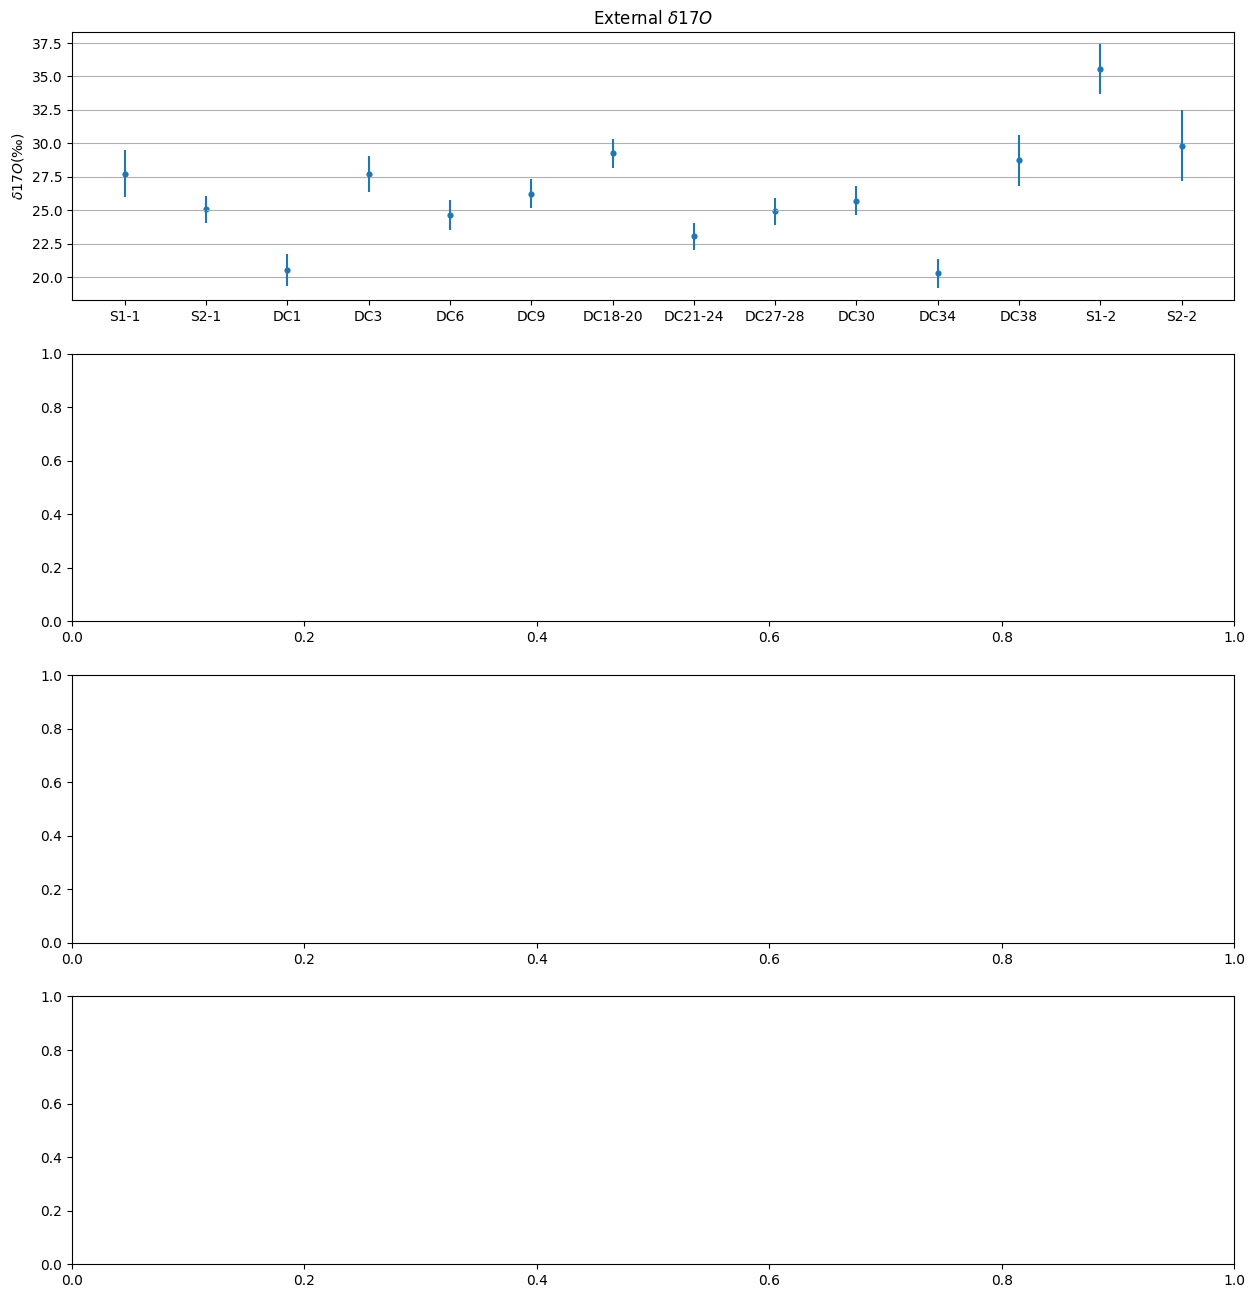

In [29]:
df = stats.copy()

# Import reference data for internal standard

references = pd.read_excel(ref_filename, index_col='sample_name')

internal_std_short = int_std.split('-')[0]
refs_stats = references.loc[internal_std_short]
refs_stats = refs_stats*1e-3

# display
print('Imported reference data for internal standard '+internal_std_short+' from '+ ref_filename)
print(refs_stats[[iso for iso in refs_stats.index if iso.startswith('mean_d')]])

# change reference to international scale based on internal standard supposed values
df_international_scale=df.copy()
for sample in df.index:
    # identify isotopologues
    isotopolog_cols = [iso for iso in df.columns if iso.startswith('mean')]
    # identify basepeak
    bp = df.loc[sample,'basepeak']
    # identify and rename the internal standard used
    int_std_name = df.loc[sample,'rel_to']
    int_std_name = int_std_name.split('-')[0]
    # select internal standard delta vals
    if int_std_name == refs_stats.name:
        if bp=='M0':
            int_std_cols = [iso for iso in isotopolog_cols  if iso in refs_stats.index ]
        elif bp in ['15N','18O']:
            int_std_cols = [iso+'/'+bp for iso in isotopolog_cols  if iso+'/'+bp in refs_stats.index ]
        else:
            print('Basepeak not identified for',sample)
        int_std_deltas = refs_stats.loc[int_std_cols]
         # correct using change of reference formula
        for col in int_std_deltas.index:
            d1 = df.loc[sample, col.split('/')[0]] # internal delta for all samples
            d2 = int_std_deltas[col]  #delta of standard
            d_corr = d1 + d2 + d1*d2
            df_international_scale.loc[sample, col.split('/')[0]] = d_corr
        df_international_scale.loc[sample,'rel_to'] = 'international reference'+' '+df.loc[sample,'basepeak']+' peak'
    else:
        print("Couldn't find standard: "+ int_std_name+ ' in reference data. Using internal deltas for '+ str(df.loc[i,'sample_name']))

# save deltas as csv
df_international_scale.to_csv(os.path.join(pathresults,'external_deltas_'+current_date_string+'.csv'))
print('Changed reference of internal deltas to international reference scale. \nSummarised output saved as '+os.path.join(pathresults,'external_deltas_'+current_date_string+'.csv'))

# plot
fig,ax = plt.subplots(len(isotopologues), figsize=[15,4*len(isotopologues)])

categories = df_international_scale.index
from matplotlib.colors import ListedColormap
tab10_cmap = plt.get_cmap('tab20')
colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
discrete_cmap = ListedColormap(colors)
category_mapping = {category: i for i, category in enumerate(categories.unique())}
numeric_categories = np.array([category_mapping[category] for category in categories])

for i,iso in enumerate(isotopologues):
    scatter = ax[i].scatter(df_international_scale.index, df_international_scale['mean_d'+iso]*1000, lw=0, marker='.',s=80)
    ax[i].errorbar(df_international_scale.index, df_international_scale['mean_d'+iso]*1000, yerr=df_international_scale['err_d'+iso]*1000, fmt='none')
    ax[i].grid(True, axis='y')
    ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
    ax[i].set_title('External $\delta' + iso +'$')
    ax[i].set_xticks(ax[i].get_xticks(),rotation=90)
    

# display
df_international_scale.map(multiply_numerical).head(20)

## Plot final results

<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\D'
<>:40: SyntaxWarning: invalid escape sequence '\D'
<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\D'
<>:40: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Thermo\AppData\Local\Temp\ipykernel_20920\4293042951.py:27: SyntaxWarning: invalid escape sequence '\d'
  ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
C:\Users\Thermo\AppData\Local\Temp\ipykernel_20920\4293042951.py:28: SyntaxWarning: invalid escape sequence '\d'
  ax[i].set_title('$\delta' + iso +'$')
C:\Users\Thermo\AppData\Local\Temp\ipykernel_20920\4293042951.py:39: SyntaxWarning: invalid escape sequence '\D'
  ax[i].set_ylabel('$\Delta^{17}O$(‰)')
C:\Users\Thermo\AppData\Local\Temp\ipykernel_20920\4293042951.py:40: SyntaxWarning: invalid escape sequence '\D'
  ax[i].set_ti

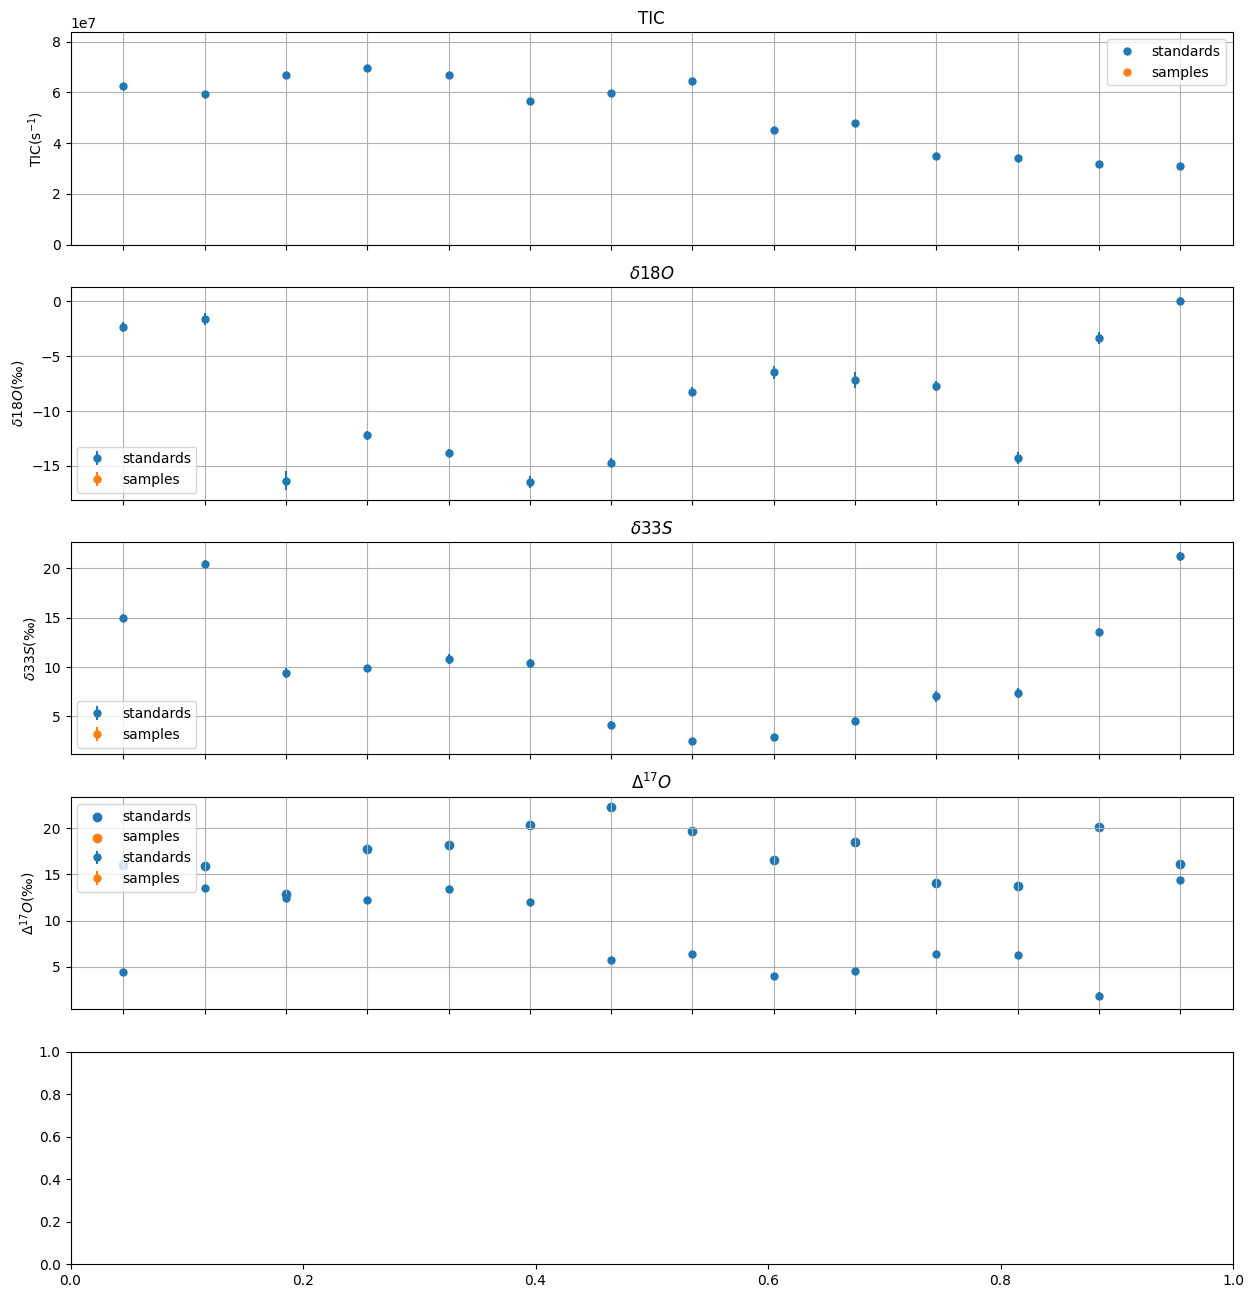

In [45]:
isotopologues_wo17 = [iso for iso in isotopologues if iso!='17O']

data = df_international_scale.copy()
data_spl = data.drop(index=[name for name in data.index if not name.startswith('C')])

fig,ax = plt.subplots(len(isotopologues_wo17)+2, figsize=[15,4*(len(isotopologues_wo17)+1)])

i=0
scatter = ax[i].errorbar([name for name in data.index], data['TIC_sample'],
                        linestyle='none',marker='o',ms=5,label='standards')
scatter = ax[i].errorbar([name for name in data_spl.index], data_spl['TIC_sample'],
                        linestyle='none',marker='o',ms=5,label='samples')
ax[i].grid(True, axis='both')
ax[i].set_ylabel('TIC(s$^{-1}$)')
ax[i].set_title('TIC')
ax[i].set_xticklabels([])
ax[i].set_ylim([0,1.2*max( data['TIC_sample'])])
ax[i].legend()

for ii,iso in enumerate(isotopologues_wo17):
    i=ii+1
    scatter = ax[i].errorbar([name for name in data.index], data['mean_d'+iso]*1000, yerr=data['err_d'+iso]*1000,
                            linestyle='none',marker='o',ms=5,label='standards')
    scatter = ax[i].errorbar([name for name in data_spl.index], data_spl['mean_d'+iso]*1000, yerr=data_spl['err_d'+iso]*1000,
                            linestyle='none',marker='o',ms=5,label='samples')
    ax[i].grid(True, axis='both')
    ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
    ax[i].set_title('$\delta' + iso +'$')
    ax[i].set_xticklabels([])
    ax[i].legend()
    
i=3
if '17O' in isotopologues and '18O' in isotopologues:
    D17 = data['mean_d17O']*1000 - 0.515* data['mean_d18O']*1000
    scatter = ax[i].scatter([name for name in data.index], D17,label='standards')
    D17 = data_spl['mean_d17O']*1000 - 0.515* data_spl['mean_d18O']*1000
    scatter = ax[i].scatter([name for name in data_spl.index], D17,label='samples')
    ax[i].grid(True, axis='both')
    ax[i].set_ylabel('$\Delta^{17}O$(‰)')
    ax[i].set_title('$\Delta^{17}O$')
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=90)
    ax[i].legend()

## 6. Save data to excel file

Saves results to the file specified in inputs, with each as a seperate sheet:
- Block average ratios, start/end times, #scans, median scan duration, average and std TIC and TICxIT
- Bracketed deltas before any correction
- Deltas after M0 correction
- Deltas after correction to international scale using value of internal standard (not calibrated)
- Summaries of mean and uncertainty of all bracketed deltas  

Note: saved delta values are not in permil


In [46]:
to_save = {'Block averages':summ,
           'Bracketed deltas':samples_delta,
           'Bracketed deltas summary':stats,
           'Referenced deltas summary':df_international_scale}

for sheet_name, df in to_save.items():
    # Check if the file exists
    if not os.path.exists(os.path.join(output_file)):
        # If the file doesn't exist, create a new ExcelWriter object without mode='a'
        with pd.ExcelWriter(os.path.join(output_file), engine='openpyxl') as writer:
            # Write the DataFrame to a new sheet with the specified sheet name
            df.to_excel(writer, sheet_name=sheet_name, index=True)
            print('Excel file created:',os.path.join(output_file),'\nNew sheet added to',output_file,':',sheet_name)
    else:
        # If the file exists, create an ExcelWriter object with mode='a' to append to the existing file
        with pd.ExcelWriter(os.path.join(output_file), engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
            # Write the DataFrame to a new sheet with the specified sheet name
            df.to_excel(writer, sheet_name=sheet_name, index=True)
            print('New sheet added to',output_file,':',sheet_name)

Excel file created: results_2024-10-07.xlsx 
New sheet added to results_2024-10-07.xlsx : Block averages
New sheet added to results_2024-10-07.xlsx : Bracketed deltas
New sheet added to results_2024-10-07.xlsx : Bracketed deltas summary
New sheet added to results_2024-10-07.xlsx : Referenced deltas summary
